# Cash Flow Model Development
`AUTHOR = 'Firas Obeid'`

In [273]:
#Core Packages
import pandas as pd
import numpy as np
# API KEYS AND SECRETS LOAD
# !pip install python-dotenv
from dotenv import load_dotenv
import os
#Plotting libraries
import matplotlib.pyplot as plt
import hvplot.pandas
import seaborn as sns
sns.set_style('ticks')
sns.set_context('poster')
plt.rcParams["figure.figsize"]=20,8
#filter harmless warnings
import warnings
warnings.filterwarnings("ignore")
# Custom Functions
import sys
# sys.path.insert(1, 'C:/Users/fobeid/Desktop/Credit/Projects/Data_Sources_Analysis/DSM_Modelling_Projects_2023/utility')
# sys.path.insert(1, 'C:/Users/fobeid/Desktop/Credit/Projects/Data_Sources_Analysis/DSM_Modelling_Projects_2023/CCR2/Notebooks/scripts')
from utils import *
#configure dataframe display options
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
pd.set_option('display.float_format', '{:.5f}'.format)

In [200]:
#filter harmless warnings
import warnings
warnings.filterwarnings("ignore")
sns.set(style = "whitegrid")
#configure dataframe display options
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
pd.set_option('display.float_format', '{:.5f}'.format)  # Show 2 decimal places

In [364]:
# Summary tearsheet dependencies
from watermark import watermark
print(watermark())
print(watermark(iversions=True, globals_=globals()))

Last updated: 2025-10-22T01:07:54.554512-04:00

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.12.3

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 12
Architecture: 64bit

sys              : 3.8.15 (default, Nov 24 2022, 14:38:14) [MSC v.1916 64 bit (AMD64)]
optuna           : 4.1.0
xgboost          : 1.7.3
seaborn          : 0.12.2
category_encoders: 2.6.4
json             : 2.0.9
psutil           : 6.1.0
pandas           : 1.5.2
matplotlib       : 3.6.2
platform         : 1.0.8
hvplot           : 0.8.2
numpy            : 1.22.4



## Problem Statament

* Guidelines
The goal of the project is to build a model to predict column A (initial cash advance defaults).  0 is a successful payment, and 1 is a default.  You can use existing variables or come up with any transformations you think are valuable.  
For this exercise, focus on building an end to end model:

* Overall modeling process
* Data, feature and modeling choice and rationale
* The choice of metrics to evaluate model performance/accuracy
* Model optimization
* Coding standards and engineering practices


## Data 

In [4]:
df = pd.read_csv(r'https://raw.githubusercontent.com/firobeid/Cash_Advance_Default_Modelling/refs/heads/main/data/Data.csv')

In [6]:
df.info(memory_usage = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 32 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   DefaultedAdvances                               11808 non-null  int64  
 1   AdvanceAmount                                   11808 non-null  int64  
 2   CurrentBalance                                  8748 non-null   float64
 3   LatefeesTotalCount                              11808 non-null  int64  
 4   CreditAccounts                                  11808 non-null  int64  
 5   LastRepaymentAmount                             11808 non-null  float64
 6   OverdraftCount                                  11808 non-null  int64  
 7   OverdraftTotal                                  11808 non-null  int64  
 8   AverageMonthlySpend                             11808 non-null  float64
 9   BalanceAverage                         

In [33]:
df.shape

(11808, 32)

In [339]:
dictionary = pd.read_csv(r'https://raw.githubusercontent.com/firobeid/Cash_Advance_Default_Modelling/refs/heads/main/data/Data_dictionary.csv')

In [340]:
dictionary

,Variable,Description
0,DefaultedAdvances,Target variable - whether or not they repaid t...
1,AdvanceAmount,Cash advance amount in dollars
2,CurrentBalance,Balance on the user's primary checking account...
3,LatefeesTotalCount,Total number of late fees on external checking...
4,CreditAccounts,Number of credit accounts they've connected to...
5,LastRepaymentAmount,Amount of most recent debt payment on credit a...
6,OverdraftCount,Total number of overdrafts on external checkin...
7,AverageMonthlySpend,Average spending on external checking account
8,BalanceAverage,Average balance on external checking acocunt
9,BalanceMin,Minimum all time balance on external checking


In [29]:
def check_description(feature_name):
    global dictionary
    '''
    Check a columns/features Description from the key
    '''
    print(dictionary.loc[dictionary['Variable'] == feature_name,'Description'].iloc[0])

In [30]:
check_description('ErrorRate')

Number of errors in the paycheck sequence (e.g., instances where paycheck is a day early or late)


In [25]:
df['ErrorRate'].value_counts() # this should be interesting in showing paycheck stability and I assume that would be ranked towards the top

0.00000    9603
1.00000    1816
2.00000      97
3.00000       7
Name: ErrorRate, dtype: int64

* AdvanceAmount causes target leakge as it exists at the time of the target varibale maturation
* PaycheckModelUsed seems to be the only object column

In [31]:
check_description('PaycheckModelUsed')

One of two models we have for detecting a paycheck


In [32]:
df['PaycheckModelUsed'].value_counts(dropna = False, normalize = 1)

BruteForce              0.96248
Tagging                 0.02236
DeepSearch              0.01169
VariableIncomeInMonth   0.00339
None                    0.00008
Name: PaycheckModelUsed, dtype: float64

* The decription above seems to be outdated and something we need to follow up on. From AIR Leanding Act concerns, I am not sure if this feature is acceptable given that we have to provide customers with adverse action report within 30 days based on the top4 features contributing to there prediction

In [50]:
check_description('Paycheck')

Estimated income from all paychecks detected


In [55]:
(df['Paycheck'] == 0).sum() 

0

* Great all paychecks where dtected and that adhere with the decsriptions and apporavl requirement

In [9]:
df.head()

,DefaultedAdvances,AdvanceAmount,CurrentBalance,LatefeesTotalCount,CreditAccounts,LastRepaymentAmount,OverdraftCount,OverdraftTotal,AverageMonthlySpend,BalanceAverage,BalanceMin,TotalAssets,AverageNumberOfTransactionsADay,TotalCash,LatefeesCount,Paycheck,TotalHistoryInDays,AverageMonthlyIncome,AverageMonthlyDiscretionarySpend,CheckingAccountCount,CreditAccountCount,SavingsAccountCount,OutstandingCreditDebtWherePayingInterest,AverageNumberOfTransactionsADayPrimaryChecking,NegativeBalanceCount,PaycheckModelUsed,NumberOfMatches,ErrorRate,IsNameBased,BalanceAbove100L30Count,AveragePotentialMonthlyIncome,HasEmpowerBanking
0,0,50,268.10000,0,0,0.00000,0,0,-5491.06000,345.11000,-185.34000,268.10000,4.63333,268.10000,0,2457.00000,61.17987,3969.46118,-1191.27000,1,0,1,0.00000,4.63333,11,BruteForce,5.00000,0.00000,1.00000,18,4398.50667,1
1,0,50,17.68000,0,0,0.00000,0,0,-1330.75993,378.01000,0.08000,17.72000,1.64758,17.72000,0,1706.90000,128.70692,1120.50679,-1503.20000,1,0,2,0.00000,4.76378,0,BruteForce,7.00000,0.00000,0.00000,28,3436.18000,0
2,0,50,0.79000,0,0,0.00000,0,0,-6446.75388,559.13000,-276.61000,273.99000,4.08094,273.99000,0,4630.34722,558.40166,6674.56729,-1546.52333,1,0,1,0.00000,3.56295,20,BruteForce,5.00000,0.00000,1.00000,16,6803.28000,1
3,0,50,-12.83000,0,0,0.00000,0,0,-1904.71424,124.86000,-44.62000,645.12000,2.83158,645.12000,0,1300.00000,285.77687,1787.24171,-940.61667,1,0,1,0.00000,2.72982,15,BruteForce,3.00000,0.00000,0.00000,15,0.00000,0
4,0,50,55.88000,0,0,0.00000,0,0,-5857.24106,420.26000,42.50000,55.88000,8.92683,55.88000,0,3633.07333,165.99059,5169.47022,-1893.43333,1,0,0,0.00000,8.92683,0,BruteForce,3.00000,0.00000,0.00000,24,7390.74667,1


In [10]:
df.tail()

,DefaultedAdvances,AdvanceAmount,CurrentBalance,LatefeesTotalCount,CreditAccounts,LastRepaymentAmount,OverdraftCount,OverdraftTotal,AverageMonthlySpend,BalanceAverage,BalanceMin,TotalAssets,AverageNumberOfTransactionsADay,TotalCash,LatefeesCount,Paycheck,TotalHistoryInDays,AverageMonthlyIncome,AverageMonthlyDiscretionarySpend,CheckingAccountCount,CreditAccountCount,SavingsAccountCount,OutstandingCreditDebtWherePayingInterest,AverageNumberOfTransactionsADayPrimaryChecking,NegativeBalanceCount,PaycheckModelUsed,NumberOfMatches,ErrorRate,IsNameBased,BalanceAbove100L30Count,AveragePotentialMonthlyIncome,HasEmpowerBanking
11803,1,50,730.68000,0,0,0.00000,1,1,-2303.88535,66.01000,-471.14000,1528.57000,2.23077,1528.57000,0,2095.80222,91.95914,2385.63414,-136.05333,1,0,0,0.00000,2.23077,16,BruteForce,5.00000,0.00000,1.00000,15,3208.08667,0
11804,1,50,20.31000,0,0,0.00000,0,0,-2192.36260,122.33000,5.31000,20.31000,0.82022,20.31000,0,1170.00000,89.48797,2426.25561,-905.84333,1,0,0,0.00000,0.82022,0,BruteForce,3.00000,0.00000,0.00000,14,2076.47667,1
11805,1,50,0.00000,0,0,0.00000,0,0,-2398.15250,57.59000,-199.82000,-4.99000,3.64214,-4.99000,0,1228.86000,992.06694,2344.87845,-369.81333,2,0,1,0.00000,3.00000,21,BruteForce,5.00000,0.00000,1.00000,0,955.79000,1
11806,1,50,15.51000,0,0,0.00000,1,19,-1660.51700,158.86000,-111.02000,15.51000,1.22222,15.51000,0,1733.33333,434.11408,1604.88104,-332.12000,1,0,0,0.00000,1.22222,13,BruteForce,3.00000,0.00000,0.00000,9,0.00000,0
11807,1,50,-33.04000,0,0,0.00000,0,0,-4169.52849,842.25000,729.75000,739.75000,2.51981,739.75000,0,2061.44000,430.31722,4145.52447,-878.76667,2,0,3,0.00000,1.96037,0,BruteForce,3.00000,0.00000,0.00000,0,2061.44000,1


In [12]:
df.isna().mean()

DefaultedAdvances                                0.00000
AdvanceAmount                                    0.00000
CurrentBalance                                   0.25915
LatefeesTotalCount                               0.00000
CreditAccounts                                   0.00000
LastRepaymentAmount                              0.00000
OverdraftCount                                   0.00000
OverdraftTotal                                   0.00000
AverageMonthlySpend                              0.00000
BalanceAverage                                   0.00000
BalanceMin                                       0.00000
TotalAssets                                      0.00000
AverageNumberOfTransactionsADay                  0.00000
TotalCash                                        0.00000
LatefeesCount                                    0.00000
Paycheck                                         0.00000
TotalHistoryInDays                               0.00000
AverageMonthlyIncome           

* Missing rates are pretty low, ususally I look at 1000+columns and missing rate start at 100% and go down to zero

In [19]:
df.describe(percentiles = [0.001,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,0.999]).T

,count,mean,std,min,0.1%,1%,5%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
DefaultedAdvances,11808.00000,0.22790,0.41949,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,1.00000
AdvanceAmount,11808.00000,50.00000,0.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000,50.00000
CurrentBalance,8748.00000,133.14083,427.86386,-987.56000,-430.38182,-99.36000,-49.87950,-31.54900,0.06000,11.72500,114.33250,422.55900,718.20750,1507.97600,4702.86887,19002.09000
LatefeesTotalCount,11808.00000,0.11619,1.04941,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,4.00000,17.00000,34.00000
CreditAccounts,11808.00000,0.08816,0.38248,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,4.00000,13.00000
LastRepaymentAmount,11808.00000,11.95148,142.96003,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,259.69620,1556.37353,8120.00000
OverdraftCount,11808.00000,1.80174,4.58717,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,6.00000,10.00000,22.00000,42.19300,80.00000
OverdraftTotal,11808.00000,6.89312,20.09222,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,19.00000,34.00000,89.93000,190.54400,536.00000
AverageMonthlySpend,11808.00000,-3741.36347,2648.07591,-79863.13060,-25736.42477,-12962.38917,-7995.71767,-6440.78906,-4604.76615,-3191.04387,-2172.37003,-1431.15503,-1074.16999,-558.52261,-257.59535,-28.22249
BalanceAverage,11808.00000,418.37462,12496.39021,-888820.57000,-2027.03777,-271.94000,18.94150,65.11700,147.54500,286.38500,535.68750,995.08200,1490.62000,3311.37210,8689.41473,878155.10000


* I usually look at variables ditirbutions when I have my final feature set given that I am using tree models. If I am using linear models (Logestic Regression for example) I would definitetly look at distributions beforehand. If I am using a linear model (based on its performance, that would allow me to decide if I choose it, I would floor any feature at its 0.1% or 1% and cap them respectively at 99% or 99.9%)
* Seem our target leakage column also has an std off which means it has the same values across the board.

In [22]:
drop_features = []
drop_features.append('AdvanceAmount')

### Target Variable

In [34]:
df['DefaultedAdvances'].isna().sum()

0

In [36]:
df['DefaultedAdvances'].value_counts(1)

0   0.77210
1   0.22790
Name: DefaultedAdvances, dtype: float64

* Not bad distribution. Anthing above 1% can be handled by boosting models with decent hyperparamter tuning, from my experience.

### Redundant Columns
* These function I have coded in my past and use them at the start off any project

In [37]:
def calculate_conditions(df_np, missing_threshold):  
    missing = np.mean(np.isnan(df_np), axis=0) > missing_threshold  
    non_variating = np.apply_along_axis(lambda x: len(np.unique(x)) <= 1, axis=0, arr=df_np)  
    return missing, non_variating  
  
def drop_non_informative_columns(df, missing_threshold=0.99):  
    global missing_non_numeric, non_variating_non_numeric, missing, non_variating
    # Separate numeric and non-numeric columns  
    numeric_cols = df.select_dtypes(include=np.number).columns  
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns  
  
    # Convert DataFrame to NumPy array for numeric columns  
    df_numeric_np = df[numeric_cols].values  
  
    # Compute conditions on NumPy array  
    missing, non_variating = calculate_conditions(df_numeric_np, missing_threshold)  
  
    # Columns to drop for numeric columns  
    drop_columns_numeric = numeric_cols[missing | non_variating]  
  
    # Compute conditions for non-numeric columns  
    missing_non_numeric = df[non_numeric_cols].isna().mean() > missing_threshold  
    non_variating_non_numeric = df[non_numeric_cols].nunique() <= 1  
  
    # Columns to drop for non-numeric columns  
    drop_columns_non_numeric = non_numeric_cols[missing_non_numeric | non_variating_non_numeric]  
  
    # Combine all columns to drop  
    drop_columns = list(drop_columns_numeric) + list(drop_columns_non_numeric)  
  
    # Drop columns from DataFrame  
    df.drop(drop_columns, axis=1, inplace=True)  
  
    return df  
def get_uninformative_columns(df, threshold=0.95):  
    """  
    Identify columns from a dataframe that have one category which appears more than 'threshold' proportion.  
  
    :param df: Input dataframe  
    :param threshold: Proportion threshold, default 0.95  
    :return: List of uninformative column names  
    """  
    uninformative_columns = []  
    for column in tqdm(df.select_dtypes(include=['object', 'category']).columns):  
        max_proportion = df[column].value_counts(normalize=True).values[0]  
        if max_proportion > threshold:  
            uninformative_columns.append(column)  
    return uninformative_columns 

In [39]:
temp = drop_non_informative_columns(df[df.columns.to_list()])

In [41]:
len(missing_non_numeric), len(non_variating_non_numeric)

(1, 1)

In [43]:
temp.shape

(11808, 31)

In [44]:
temp = drop_non_informative_columns(temp)

In [46]:
temp.shape

(11808, 31)

In [62]:
missing_non_numeric

PaycheckModelUsed    False
dtype: bool

In [48]:
dropped = set(df[df.columns.to_list()]).difference(set(temp.columns))

In [49]:
dropped

{'AdvanceAmount'}

* There are no categorical or numeric columns that are all missing but there is one non-variating column that has the same values and we already saw that before.

## Convert Categorical Columns
* For some quick analysis, this code will convert all object columns to numeric representation (although we have only 1 column that is an object but I like to be mainstream in my code)
* Categorical column processing will be built in our pipeline later for the modelling part.

In [ ]:
PaycheckModelUsed    

In [90]:
categorical_vars = list(temp.columns[temp.dtypes == object].values)
obj_df = temp.select_dtypes(include=['object']).copy() 
map_dict = {col: {n: cat for n, cat in enumerate(obj_df[col].astype('category').cat.categories)} for col in obj_df}
obj_df = pd.DataFrame({col: obj_df[col].astype('category').cat.codes for col in obj_df}, index=obj_df.index)

In [93]:
temp[categorical_vars] = obj_df[categorical_vars]

In [94]:
del obj_df
obj_df = None #meemory efficieny

In [98]:
temp['PaycheckModelUsed'].value_counts(1) #although 2 (None) has only 1 observation, we can investigate that with the tech team or drop it but we ill keep it

0   0.96248
3   0.02236
1   0.01169
4   0.00339
2   0.00008
Name: PaycheckModelUsed, dtype: float64

## VARIANCE THRESHOLDING
* Drop features that have very low standard variation comapred to the mean std across the features, after coercing there ditribution for this analysis
* Although some features might have low STD/variation and might have predicitve power but ML is all about variation in the data. We can prove to MRM team that if we the proposed drops from this step would hurt the model performance or not by developling a model with them and without them

In [65]:
import json
def std_trimming(df, features, object_columns, thresh,NAN_THRESH):
    global std_df, null_features
    from sklearn.preprocessing import QuantileTransformer
    q_scaler = QuantileTransformer(n_quantiles = 100, random_state = 42)
    temp = q_scaler.fit_transform(df[list(set(features) - set(object_columns))])
    # temp.describe(percentiles = [0.01,0.05,0.1,0.25,0.5,0.75,0.95,0.99]).T

    temp = pd.DataFrame(temp, columns = list(set(features) - set(object_columns)))

    std_df = temp.describe().T[['std']]

    print("The group's average standard deviation is %f" % std_df.mean())

    drop = std_df[std_df['std'] < thresh].index.to_list() # TRY another threshold: drop = std[std['std'] < std.quantil(0.2)[0]].index.to_list() or Info Value can confirm that these are worth dropping
    # std[std['std'] < std.mean()[0]].to_clipboard()

    all_features = list(set(features) - set(drop))
    with open('../Artifacts/Features_%.2f_pctNULL.json'%NAN_THRESH, 'w', encoding='utf-8') as f:
        json.dump(all_features, f, ensure_ascii=False, indent=4)
        
    with open('../Artifacts/dropped_features.json', 'w', encoding='utf-8') as f:
        json.dump(drop + null_features, f, ensure_ascii=False, indent=4)
    # feature_groups = drop_features(drop)
    # df = df.drop(final_drop, axis = 1)
    print("The candidate features remaining are: %d" %(len(all_features)))
    print("The candidate features to be dropped based standard deviation threshold are: %d " %(len(drop)))
    
    print(memory())

In [70]:
feature_list = temp.columns.to_list()

In [73]:
NAN_THRESH = 0.90

null_features = temp.isnull().sum()[temp.isnull().sum() > NAN_THRESH * temp.shape[0]].index.to_list()
final_features = list(set(feature_list) - set(null_features))
temp_df = temp
neglect = list(temp_df.select_dtypes(include=['datetime', "category","object"]).columns) #remove binary and target variable :[cols for cols in df.columns if df[cols].nunique() <= 2] + 

print('Nulls Features dropped: %d \nFeatures left: %d' %(len(null_features), len(final_features)))

std_trimming(temp_df, final_features, neglect, thresh=1e-12, NAN_THRESH=NAN_THRESH)

STD_THRESHOLDS = std_df.describe(percentiles = [0.05, 0.1,0.25,0.5,0.75,0.9,0.99]).sort_values(by = 'std').iloc[:-2].T

std_intervals = np.append(STD_THRESHOLDS.values.ravel(), std_df['std'].max())
std_labels = ["<"+i for i in STD_THRESHOLDS.columns.to_list()[1:]]
std_labels.append('<=100%')

# Remove duplicate bin edges
std_intervals_unique = np.unique(std_intervals)

# Adjust labels to match the number of unique intervals
std_labels_adjusted = std_labels[:len(std_intervals_unique)-1]

std_df['THRESHOLDS_FEATURE_DROP_COUNT'] = pd.cut(std_df['std'], 
                                                 std_intervals_unique, 
                                                 labels=std_labels_adjusted, 
                                                 right=False, 
                                                 retbins=True)[0]
std_df.index.name = 'features'

final_stds = std_df['THRESHOLDS_FEATURE_DROP_COUNT'].value_counts().to_frame()
final_stds.index = final_stds.index.astype(str)
final_stds = final_stds.reindex(["<"+i for i in STD_THRESHOLDS.columns.to_list()[1:]])
final_stds.loc['<=100%', 'THRESHOLDS_FEATURE_DROP_COUNT'] = len(std_df) - final_stds.sum()[0]
final_stds['STD_VALUE'] = std_intervals[1:]
final_stds.index.name = 'STDEV_Quantile_Threshold'
final_stds['THRESHOLDS_FEATURE_DROP_COUNT'] = final_stds['THRESHOLDS_FEATURE_DROP_COUNT'].cumsum()

Nulls Features dropped: 0 
Features left: 31
The group's average standard deviation is 0.305844
The candidate features remaining are: 31
The candidate features to be dropped based standard deviation threshold are: 0 
used: 87.3% free: 1.88GB
None


In [74]:
final_stds

,THRESHOLDS_FEATURE_DROP_COUNT,STD_VALUE
STDEV_Quantile_Threshold,,
<min,0.00000,0.10801
<5%,2.00000,0.13918
<10%,3.00000,0.20096
<25%,8.00000,0.28808
<50%,15.00000,0.28869
<mean,19.00000,0.30584
<75%,22.00000,0.35434
<90%,27.00000,0.39961
<99%,29.00000,0.49277


* All features have less than 90% missing rate, which is considered aggressive 
* There are 15 features below the mean std of all feature's stds; but we have a samll feature set thus we will not drop anything

## Correlation Drops

To calculate feature correlation given features exhibited high correlations and adversial behavior to other feature splits
```python
A B C
A + B 0.8
C + A 0.5
B + C 0.7

A + B 0.8 --> A + TARGET: 0.01 VS B +TARGET:0.005

A C
```
* Although corrleation is a linear measure and tre emodels can handel cirrleated variables and do not run into multi-colinearaity issue, but its it a good practice to drop features with very high correlation. A threshold off 0.8 is an industry practice.

In [113]:
def flatten(iterable):
    import collections.abc as a
    for el in iterable:
        if isinstance(el, a.Iterable) and not isinstance(el, str): 
            yield from flatten(el)
        else:
            yield el

def corr_feature_pairs(df, feature_list, thresh=0.79):
    '''
    Returns: df with feature pairs that have a correlation higher than the passed threshold
    '''
    corrmat = df[feature_list].corr('spearman')
    corrmat = corrmat.abs().unstack()  # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'correlation']
    
    # Filter correlations above threshold and remove self-correlations
    filter_out_corrs = corrmat[
        (corrmat.feature1 != corrmat.feature2) & 
        (corrmat.correlation > thresh)
    ].sort_values(by='correlation', ascending=False)
    
    # Remove duplicate pairs by sorting feature names and dropping duplicates
    filter_out_corrs['feature_pair'] = filter_out_corrs.apply(
        lambda x: tuple(sorted([x['feature1'], x['feature2']])), axis=1
    )
    filter_out_corrs = filter_out_corrs.drop_duplicates('feature_pair', keep='first')
    filter_out_corrs = filter_out_corrs.drop('feature_pair', axis=1).reset_index(drop=True)
    
    return filter_out_corrs

def choose_corr_drop(df):
    if df['importance1'] > df['importance2']: 
        return df['feature2']
    elif df['importance1'] < df['importance2']:
        return df['feature1']
    elif df['importance1'] == df['importance2']:
        return [df['feature1'], df['feature2']]
    else:
        return np.nan

def corr_drop_feature_list(df,features_list, 
                           importance_df,
                           corr_thresh = 0.79,
                           importance = True,
                           ):
    
    if importance == True:
        # features_list_stats = get_feature_list_stats(features_list)
        features_list_stats = importance_df
        filter_out_corrs = corr_feature_pairs(df, features_list, thresh = corr_thresh)
        
        feature1 = features_list_stats.loc[features_list_stats.index.intersection(filter_out_corrs['feature1']), ['importance']].rename_axis(index = 'feature1')
        feature2 = features_list_stats.loc[features_list_stats.index.intersection(filter_out_corrs['feature2']), ['importance']].rename_axis(index = 'feature2')
        print(feature1)
        print(feature2)
        remove_corr_df = filter_out_corrs.join(feature1, on = 'feature1').join(feature2, on = 'feature2', lsuffix = "1", rsuffix = "2").fillna(0.0)
        print(remove_corr_df)
        if len(remove_corr_df.apply(choose_corr_drop, axis = 1)) < 1:
            return []
        
        drop_features = remove_corr_df.apply(choose_corr_drop, axis = 1).to_list()
        drop_features = list(set(list(flatten(drop_features))))
        # filter_out_corrs.to_csv('corr_analysis1.csv',index = False)
        # remove_corr_df.to_csv('corr_analysis2.csv',index = False)   ####
    # elif feature_importance == True: --> This is another mythology I use sometimes
    else: 
        print('Please pass either feature_impact or importance to True')
        return None
    

    return drop_features

In [180]:
from collections import Counter



def calculate_gini(y):
    '''
    Gini impurity value, which ranges from 0 to (1 - 1/C), where C is the number of classes.
    '''
    if len(y) == 0:
        return 0
    counts = Counter(y)
    total = len(y)
    proportions = [count/total for count in counts.values()]
    return 1 - sum(p*p for p in proportions)

def calculate_normalized_gini(y):
    '''
    max_gini is calculated as (num_classes - 1) / num_classes, which is the maximum possible Gini impurity for the given number of classes.
    This ensures the Gini index is always between 0 and 1, with 0 indicating perfect purity and 1 indicating maximum impurity.
    '''
    gini = calculate_gini(y)
    unique_values = set(y)
    if len(unique_values) == 1:
        return 0
    max_gini = (len(unique_values) - 1) / len(unique_values)
    return gini / max_gini

def find_best_split(X, y, feature, verbose=False):
    """
    Find best split point for a feature by checking between all adjacent values.
    """
    # Convert to numpy array and sort
    x_values = X[feature].values
    sort_idx = np.argsort(x_values)
    sorted_x = x_values[sort_idx]
    sorted_y = np.array(y)[sort_idx]
    
    # Get unique values in sorted order
    unique_vals = np.unique(sorted_x)
    
    if len(unique_vals) == 1:
        return None, 0,0,0
    
    # Calculate split points between adjacent unique values
    split_points = [(unique_vals[i] + unique_vals[i+1])/2 
                   for i in range(len(unique_vals)-1)]
    
    if verbose:
        print(f"\nFeature '{feature}':")
        print(f"Sorted unique values: {unique_vals}")
        print(f"Possible split points: {split_points}")
    
    best_gain = -float('inf')
    best_split = None
    
    parent_gini = calculate_normalized_gini(sorted_y)
    
    for split in split_points:
        left_mask = sorted_x <= split
        y_left = sorted_y[left_mask]
        y_right = sorted_y[~left_mask]
        
        if len(y_left) == 0 or len(y_right) == 0:
            continue
            
        n_left = len(y_left)
        n_right = len(y_right)
        n_total = n_left + n_right
        
        weighted_child_gini = (
            (n_left/n_total) * calculate_normalized_gini(y_left) +
            (n_right/n_total) * calculate_normalized_gini(y_right)
        )
        
        gain = parent_gini - weighted_child_gini
        
        if verbose:
            print(f"\nTrying split at {split:.2f}:")
            print(f"Left node: {sorted_x[left_mask]} → labels: {y_left}")
            print(f"Right node: {sorted_x[~left_mask]} → labels: {y_right}")
            print(f"Normalized Gini gain: {gain:.4f}")
        
        if gain > best_gain:
            best_gain = gain
            best_parent_gini = parent_gini
            best_child_gini = weighted_child_gini
            best_split = split
    
    return best_split, best_gain, best_parent_gini,best_child_gini
    
def get_feature_list_stats(df: pd.DataFrame, target_col: str, feature_list: list): 
    '''
    Calculates Gini gain for features in binary classification.
    Gini gain measures how well a feature separates the target classes.
    '''
    
    # Calculate Gini gain for each feature in feature_list
    feature_stats = []
    
    for feature in feature_list:
        if feature in df.columns and feature != target_col:
            # Remove NaN values for this feature
            valid_mask = df[feature].notna() & df[target_col].notna()
            X_valid = df.loc[valid_mask, [feature]]
            y_valid = df.loc[valid_mask, target_col]
            
            if len(X_valid) > 0:
                best_split, best_gain, parent_gini, child_gini = find_best_split(
                    X_valid, y_valid, feature, verbose=False
                )
                
                if best_split is not None:
                    feature_stats.append((feature, best_gain, best_split, parent_gini, child_gini))
    
    # Create DataFrame
    stats_df = pd.DataFrame(
        feature_stats, 
        columns=["feature", "gini_gain", "best_split", "parent_gini", "child_gini"]
    )
    stats_df = stats_df.set_index('feature').sort_values("gini_gain", ascending=False)
    
    return stats_df

* Gini (Lower is better) tells us how pure or impure a feature is in splitting the atrget variable while information gain from splitting on this feature (higher is better)

In [101]:
importance = get_feature_list_stats(temp, target_col='DefaultedAdvances', feature_list=temp.columns.to_list())

In [106]:
importance

,gini_gain,best_split,parent_gini,child_gini
feature,,,,
CurrentBalance,0.02497,3.49500,0.70218,0.67722
BalanceAverage,0.02214,184.13000,0.70384,0.68170
AverageMonthlyDiscretionarySpend,0.01930,-374.17000,0.70384,0.68454
TotalAssets,0.01513,1.12500,0.70384,0.68870
TotalCash,0.01511,1.12500,0.70384,0.68873
NegativeBalanceCount,0.01425,11.50000,0.70384,0.68959
AverageMonthlySpend,0.01309,-2889.66365,0.70384,0.69075
OverdraftTotal,0.01189,0.50000,0.70384,0.69195
AverageMonthlyIncome,0.01165,3302.12437,0.70384,0.69219


In [108]:
importance.rename(columns = {'gini_gain':'importance'}, inplace = True)

* Seems balance related features are the best is splitting `DefaultedAdvances`
* Now I can use the balance `gini_gain` as an importance criteria to decide whoch side of the correlation pair to drop

In [76]:
target = 'DefaultedAdvances'

In [87]:
temp.columns

Index(['DefaultedAdvances', 'CurrentBalance', 'LatefeesTotalCount',
       'CreditAccounts', 'LastRepaymentAmount', 'OverdraftCount',
       'OverdraftTotal', 'AverageMonthlySpend', 'BalanceAverage', 'BalanceMin',
       'TotalAssets', 'AverageNumberOfTransactionsADay', 'TotalCash',
       'LatefeesCount', 'Paycheck', 'TotalHistoryInDays',
       'AverageMonthlyIncome', 'AverageMonthlyDiscretionarySpend',
       'CheckingAccountCount', 'CreditAccountCount', 'SavingsAccountCount',
       'OutstandingCreditDebtWherePayingInterest',
       'AverageNumberOfTransactionsADayPrimaryChecking',
       'NegativeBalanceCount', 'PaycheckModelUsed', 'NumberOfMatches',
       'ErrorRate', 'IsNameBased', 'BalanceAbove100L30Count',
       'AveragePotentialMonthlyIncome', 'HasEmpowerBanking'],
      dtype='object')

In [111]:
corr_df = corr_feature_pairs(temp.drop(target, axis = 1) ,
                             temp.drop(target, axis = 1).columns.to_list(), 
                             thresh=0)
corr_df.head(10)

,feature1,feature2,correlation
0,CreditAccounts,CreditAccountCount,1.00000
1,TotalAssets,TotalCash,0.99355
2,AverageNumberOfTransactionsADayPrimaryChecking,AverageNumberOfTransactionsADay,0.90392
3,AverageMonthlyIncome,AverageMonthlySpend,0.89037
4,OverdraftCount,OverdraftTotal,0.82960
5,CreditAccountCount,OutstandingCreditDebtWherePayingInterest,0.80741
6,CreditAccounts,OutstandingCreditDebtWherePayingInterest,0.80741
7,LastRepaymentAmount,CreditAccountCount,0.78532
8,LastRepaymentAmount,CreditAccounts,0.78532
9,OutstandingCreditDebtWherePayingInterest,LastRepaymentAmount,0.73133


* There seems to be really high correlated features ans=d some are almost identical. We will drop the hgh correlated ones based on our algorithm logic

In [115]:
corr_drops = corr_drop_feature_list(temp, 
                       temp.drop(target, axis = 1).columns.to_list(), 
                       importance)

                                                importance
feature1                                                  
TotalAssets                                        0.01513
AverageMonthlyIncome                               0.01165
AverageNumberOfTransactionsADayPrimaryChecking     0.01158
OverdraftCount                                     0.00497
CreditAccountCount                                 0.00326
CreditAccounts                                     0.00326
                                          importance
feature2                                            
TotalCash                                    0.01511
AverageMonthlySpend                          0.01309
OverdraftTotal                               0.01189
AverageNumberOfTransactionsADay              0.00722
CreditAccountCount                           0.00326
OutstandingCreditDebtWherePayingInterest     0.00254
                                         feature1  \
0                                  CreditAccounts  

In [116]:
corr_drops

['CreditAccountCount',
 'AverageMonthlyIncome',
 'OverdraftCount',
 'CreditAccounts',
 'AverageNumberOfTransactionsADay',
 'TotalCash',
 'OutstandingCreditDebtWherePayingInterest']

In [130]:
len(corr_drops)

7

In [118]:
drop_features.append(corr_drops)

In [122]:
drop_features = list(flatten(drop_features))

## Modelling

In [126]:
df.loc[df.duplicated()] # ok great, no duplicate rows that might caue data leakage

,DefaultedAdvances,AdvanceAmount,CurrentBalance,LatefeesTotalCount,CreditAccounts,LastRepaymentAmount,OverdraftCount,OverdraftTotal,AverageMonthlySpend,BalanceAverage,BalanceMin,TotalAssets,AverageNumberOfTransactionsADay,TotalCash,LatefeesCount,Paycheck,TotalHistoryInDays,AverageMonthlyIncome,AverageMonthlyDiscretionarySpend,CheckingAccountCount,CreditAccountCount,SavingsAccountCount,OutstandingCreditDebtWherePayingInterest,AverageNumberOfTransactionsADayPrimaryChecking,NegativeBalanceCount,PaycheckModelUsed,NumberOfMatches,ErrorRate,IsNameBased,BalanceAbove100L30Count,AveragePotentialMonthlyIncome,HasEmpowerBanking


In [127]:
features = set(df.drop(target, axis = 1).columns.to_list()) - set(drop_features)

In [129]:
len(features)

23

### Train / Test Split
* I have seen that random splitting works best if the data is iid and also works in portfolio models as well, no data leakage concern there

In [138]:

X = df.drop(target, axis = 1)[features].copy()
y = df.loc[:, target].copy()

In [139]:
X.shape, y.shape

((11808, 23), (11808,))

* Since our data set is already small, w dont have flexibilty to split the data to train, Validation and test. Thus we will only split to train and validation and we can collect OOT sample later.

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, 
                                                    test_size=0.3, # I started with 0.2 but I want enough validation data thus 0.3
                                                    random_state=42, 
                                                    stratify = y)

In [142]:
X_train.shape, X_temp.shape

((8265, 23), (3543, 23))

In [143]:
y_train.shape, y_temp.shape

((8265,), (3543,))

In [136]:
df['PARTITION'] = np.nan
df.loc[df.index.isin(X_train.index),'PARTITION'] = 'T'
df.loc[df.index.isin(X_temp.index),'PARTITION'] = 'V'

In [137]:
df.groupby('PARTITION', dropna = False).agg(
                                   App_Count = (target, 'count'), 
                                   Target_mean = (target, 'mean'),
                                 ).reindex(['T','V'], level = 0)#.to_clipboard()

,App_Count,Target_mean
PARTITION,,
T,8265,0.22795
V,3543,0.22777


### AutoML
* I usually use a platform that runs aitoml and I have written some heuristics feature reduiction algorithm based on that. Since our feature set is small, and we already dropped features then that is fine. For the autoML demo however, I will use this package:
  
```python
  pip install lazypredict
```

* In Credit Risk, its an industry standard to use KS mteric over AUC (which is threshold based and tends to be skewed based on unbalanced data "research findings").  In this method, you directly compare the predicted scores or probabilities for all observations and calculate the KS statistic based on the entire dataset. You rank all the observations based on their scores and then calculate the cumulative percentage of positive outcomes. The KS statistic remains the maximum absolute difference between the cumulative percentages of positive outcomes for the two groups with the highest and lowest scores.

In [146]:
from scipy.stats import ks_2samp

In [145]:
def ks_point_estimate(y_real, y_proba):
    from scipy.stats import ks_2samp
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba
    
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]
    
    ks_ = ks_2samp(class0['proba'], class1['proba'])
    return ks_[0]

In [144]:
from lazypredict.Supervised import LazyClassifier

In [148]:
clf = LazyClassifier(
    verbose=0,
    ignore_warnings=True,
    custom_metric=ks_point_estimate, #<---- choose best over this metric
    predictions=True,
    random_state=42
)

models, predictions = clf.fit(X_train, X_temp, y_train, y_temp)

  0%|          | 0/29 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 1884, number of negative: 6381
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 8265, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227949 -> initscore=-1.219928
[LightGBM] [Info] Start training from score -1.219928


In [149]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,ks_point_estimate,Time Taken
Model,,,,,,
NearestCentroid,0.60,0.63,0.63,0.63,0.25,0.04
BernoulliNB,0.73,0.61,0.61,0.73,0.21,0.17
XGBClassifier,0.77,0.58,0.58,0.74,0.16,0.65
LGBMClassifier,0.78,0.57,0.57,0.74,0.15,0.36
AdaBoostClassifier,0.78,0.56,0.56,0.73,0.11,0.93
BaggingClassifier,0.77,0.56,0.56,0.72,0.11,1.01
PassiveAggressiveClassifier,0.71,0.55,0.55,0.70,0.10,0.06
RandomForestClassifier,0.78,0.55,0.55,0.72,0.10,2.27
DecisionTreeClassifier,0.67,0.55,0.55,0.68,0.10,0.15


* XGBClassifier seems to have the best ks on the validation set. The other 2 algorithms are not used a lot in industry , and we still need to hyperparamter tune our XGBClassifier

### Hyperparameter Tuning

  ```markdown
    1.Maximizes the KS statistic while controlling for overfitting through:
    
    An overfitting penalty based on the difference between training and validation KS scores
    
    
    2. Optimizes key XGBoost parameters that affect model complexity and generalization:
    
    max_depth: Controls tree depth
    eta: Learning rate
    min_child_weight: Minimum sum of instance weight needed in a child
    colsample_bytree: Feature sampling per tree
    subsample: Instance sampling
    gamma: Minimum loss reduction for split
    lambda: L2 regularization
    alpha: L1 regularization
    
    
    3. Uses Optuna's TPE (Tree-structured Parzen Estimators) sampler for efficient Bayesian optimization
```

```mermaid
flowchart TB
    subgraph Input ["Input Data"]
        D[X_train, y_train]
    end

    subgraph Pipeline ["Pipeline Setup"]
        subgraph PP ["Preprocessing"]
            N[Numerical Features]
            C[Categorical Features]
            N --> NI[Custom Imputer]
            N --> NS[StandardScaler]
            C --> CI[Custom Imputer]
            C --> CE[Target Encoder]
        end
        
        subgraph XGB ["XGBoost Classifier"]
            P[Initial Parameters]
            ES[Early Stopping Settings]
        end
    end

    subgraph Optuna ["Optuna Optimization"]
        direction TB
        TS[Trial Start] --> HP[Generate Hyperparameters]
        HP --> PF[Process Features]
        PF --> CV[XGBoost Cross Validation]
        
        subgraph Metrics ["Metrics Calculation"]
            KS[KS Statistic]
            OP[Overfitting Penalty]
            STD[Standard Deviation Penalty]
        end
        
        CV --> Metrics
        Metrics --> FS[Final Score]
        
        FS --> |Next Trial|TS
        FS --> |Best Score|BP[Best Parameters]
    end

    subgraph Final ["Final Model"]
        BM[Build Model with Best Params]
        FT[Final Training]
        PE[Performance Evaluation]
    end

    D --> Pipeline
    Pipeline --> Optuna
    BP --> BM
    BM --> FT
    FT --> PE

    style Input fill:#f9f,stroke:#333
    style Pipeline fill:#bbf,stroke:#333
    style Optuna fill:#bfb,stroke:#333
    style Final fill:#fbf,stroke:#333
    
    class PP,XGB,Metrics emphasis
```

In [172]:
from Local_Model import XGBoostClassifierWithEarlyStoppingNoCV, EarlyStoppingCallbackMax, NullImputa
from sklearn.metrics import roc_curve   
from typing import Tuple  
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer    
from sklearn.preprocessing import StandardScaler    
from sklearn.compose import ColumnTransformer    
from sklearn.model_selection import train_test_split    
from xgboost import XGBClassifier    
import category_encoders as ce  
from sklearn.model_selection import cross_val_score
from xgboost.callback import EarlyStopping
import xgboost as xgb  

def ks_stat(y_pred, dtrain)-> Tuple[str, float]:
    y_true = dtrain.get_label()  
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)  
    ks_stat = max(tpr - fpr)  
    return 'ks_stat', ks_stat

In [155]:
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()  
categorical_cols = X_train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()  
# Create a preprocessor for numerical columns  
numeric_transformer = Pipeline(steps=[  
    ('custome-imputer', NullImputa(min_count_na = 5, missing_indicator=False)),  
    # ('scaler', StandardScaler())
        ])  

# Create a preprocessor for categorical columns  
categorical_transformer = Pipeline(steps=[  
    ('custome-imputer', NullImputa(min_count_na = 5, missing_indicator=False)),  
    ('target_encoder', ce.TargetEncoder(drop_invariant=True))])  
 
# Combine the preprocessors using a ColumnTransformer  
preprocessor = ColumnTransformer(  
    transformers=[  
        ('num', numeric_transformer, numerical_cols),  
        ('cat', categorical_transformer, categorical_cols)])  

In [156]:
params = {}
pipeline = Pipeline(steps=[('preprocessor', preprocessor),  
                           # ('classifier', XGBoostClassifierWithEarlyStoppingNoCV(
                           #     early_stopping_rounds=20,  
                           #     nfolds=5,
                           #     **params)
                           # )
                          ])  

In [157]:
import optuna
from Local_Model import EarlyStoppingCallbackMax

In [191]:
import gc
gc.collect()

def objective(trial, X_train, features, y_train):
    """Robust Optuna objective function with improved search strategy"""
    neg_pos_ratio = len(y_train[y_train==0]) / len(y_train[y_train==1]) #<--- This is how I take care of imbalanced class

    ###TRIAL 1
    # # Use conditional parameter suggestions for better exploration
    # n_estimators = trial.suggest_int('n_estimators', 10, 100)
    # max_depth = trial.suggest_int("max_depth", 2, 5)
    # learning_rate = trial.suggest_float("learning_rate", 0.005, 0.3, log=True)
    
    # # Conditional parameters based on max_depth
    # if max_depth <= 5:
    #     min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    #     max_leaves = trial.suggest_int("max_leaves", 0, 50)  # 0 means unlimited
    # else:
    #     min_child_weight = trial.suggest_int("min_child_weight", 3, 15)
    #     max_leaves = trial.suggest_int("max_leaves", 8, 64)
    
    # # Conditional regularization based on learning rate
    # if learning_rate >= 0.1:
    #     reg_lambda = trial.suggest_float("reg_lambda", 0.1, 10.0, log=True)
    #     reg_alpha = trial.suggest_float("reg_alpha", 0.1, 5.0, log=True)
    #     gamma = trial.suggest_float("gamma", 0.1, 5.0, log=True)
    # else:
    #     reg_lambda = trial.suggest_float("reg_lambda", 0.01, 2.0, log=True)
    #     reg_alpha = trial.suggest_float("reg_alpha", 0.01, 2.0, log=True)
    #     gamma = trial.suggest_float("gamma", 0.01, 2.0, log=True)
    
    # params = {
    #     'n_estimators': n_estimators,
    #     "max_depth": max_depth,
    #     "learning_rate": learning_rate,
    #     "min_child_weight": min_child_weight,
    #     "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
    #     "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    #     "gamma": gamma,
    #     "reg_lambda": reg_lambda,
    #     "reg_alpha": reg_alpha,
    #     "max_bin": trial.suggest_categorical("max_bin", [64, 128, 256, 512]),
    #     "random_state": 42,
    #     "max_leaves": max_leaves,
    #     "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, neg_pos_ratio * 3),
    #     "objective": "binary:logistic",
    #     "booster": "gbtree",
    #     "tree_method": "hist",
    #     "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),  # Helps with imbalanced data
    #     "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    # }

    ###TRIAL 2
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 5, 50),
    "max_depth": trial.suggest_int("max_depth", 3, 5),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
    "min_child_weight": trial.suggest_int("min_child_weight", 5, 10),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.5),
    "subsample": trial.suggest_float("subsample", 0.4, 0.8),
    "gamma": trial.suggest_float("gamma", 0.1, 2.0, log=True),
    "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
    "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 5.0, log=True),
    "max_bin": trial.suggest_categorical("max_bin", [64, 128]),
    "random_state": 42,
    "max_leaves": trial.suggest_int("max_leaves", 4, 12),
    "scale_pos_weight": trial.suggest_float("scale_pos_weight", neg_pos_ratio * 0.5, neg_pos_ratio * 1.5),
    "objective": "binary:logistic",
    "tree_method": "hist"
    # "classifier__tree_method": "gpu_hist",  # Use GPU histogram algorithm
    # "classifier__gpu_id": 0  # Specify GPU device ID
    }
    n_estimators = params['n_estimators']


    eval_set = [(X_temp, y_temp)]
    
    # Adaptive early stopping based on n_estimators
    early_stopping_rounds = max(10, min(100, n_estimators // 10))
    
    early_stop = EarlyStopping(
        rounds=early_stopping_rounds,
        metric_name='ks_stat',        
        maximize=True,
        min_delta=0.0001  # Minimum improvement threshold
    )
    
    model = xgb.XGBClassifier(**params)
    
    gc.collect()
    
    try:
        model.fit(X_train, 
                  y_train,
                  eval_metric=ks_stat,
                  eval_set=eval_set, 
                  callbacks=[early_stop],
                  verbose=False)
        
        y_pred_train = model.predict_proba(X_train)[:, 1]
        y_pred_val = model.predict_proba(X_temp)[:, 1]
        
        train_ks = ks_point_estimate(y_train, y_pred_train)
        val_ks = ks_point_estimate(y_temp, y_pred_val)
        
        # Your original overfitting penalty (which is correct)
        overfitting_penalty = min(0, (val_ks - train_ks) / train_ks)
        
        # Additional stability check
        if val_ks < 0.01 or train_ks < 0.01:  # Extremely poor performance
            return -1.0
        
        # Check for extreme overfitting
        if train_ks > 0.8 and val_ks < 0.3:  # Sanity check
            return -0.5
        
        # Store metrics in trial
        trial.set_user_attr('train_ks', train_ks)
        trial.set_user_attr('val_ks', val_ks)
        trial.set_user_attr('overfitting_penalty', overfitting_penalty)
        trial.set_user_attr('hyper_parameters', model.get_params())
        trial.set_user_attr('best_iteration', model.best_iteration if hasattr(model, 'best_iteration') else None)
        trial.set_user_attr('actual_n_estimators', model.n_estimators)
        
        # Final score with your original penalty calculation
        final_score = val_ks * (1 + overfitting_penalty)
        
        return final_score
        
    except Exception as e:
        # Handle any training failures gracefully
        trial.set_user_attr('error', str(e))
        return -1.0

def optimize_hyperparameters(X_train, features, y_train, study_name, n_trials=100):
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(),
        study_name=study_name,
        storage="sqlite:///optuna_study_local.db",
    )
    
    early_stopping = EarlyStoppingCallbackMax(n_warmup=20, min_improvement=0.001)
    
    study.optimize(
        lambda trial: objective(trial, X_train, features, y_train),
        n_trials=n_trials,
        n_jobs=5,
        show_progress_bar=True,
        callbacks=[early_stopping],
        catch=(Exception,) 
    )
    if len(study.trials) == 0:
        raise RuntimeError("No trials completed successfully. System may be too constrained.")
    # print(study)
    
    best_params = study.best_params
    best_score = study.best_value
    best_trial = study.best_trial
    
    # # Update final model with best iteration from CV
    # best_params['classifier__n_estimators'] = best_trial.user_attrs['best_iteration']
    
    print("\nBest Trial:")
    print(f"Value (KS Score - Penalties): {best_score:.4f}")
    print(f"Training KS: {best_trial.user_attrs['train_ks']:.4f}")
    print(f"Val KS: {best_trial.user_attrs['val_ks']:.4f}")
    # print(f"KS Std: {best_trial.user_attrs['ks_std']:.4f}")
    print(f"Overfitting Penalty: {best_trial.user_attrs['overfitting_penalty']:.4f}")
    print(f"Hyperparameters: {best_trial.user_attrs['hyper_parameters']}")
    # print(f"Best Iteration: {best_trial.user_attrs['best_iteration']}")
    print(f"Number of completed trials: {len(study.trials)}")
    print("\nBest Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
        
    return study, best_params

In [170]:
X_train.shape

(8265, 23)

In [163]:
X_train = pipeline.named_steps['preprocessor'].fit_transform(X_train,y_train)
X_temp = pipeline.named_steps['preprocessor'].transform(X_temp)

Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....


In [166]:
X_train.shape, X_temp.shape

((8265, 23), (3543, 23))

In [167]:
preprocessor = pipeline.named_steps['preprocessor']  
numeric_column_names_after_preprocessing = preprocessor.transformers_[0][1].named_steps['custome-imputer'].column_names  

# Get the original categorical column names from the imputer
categorical_column_names_from_imputer = preprocessor.transformers_[1][1].named_steps['custome-imputer'].column_names  

# Get the actual feature names after target encoding (accounting for dropped columns)
target_encoder = preprocessor.transformers_[1][1].named_steps['target_encoder']
if hasattr(target_encoder, 'feature_names_out_'):
    categorical_column_names_after_preprocessing = target_encoder.feature_names_out_
elif hasattr(target_encoder, 'get_feature_names_out'):
    try:
        categorical_column_names_after_preprocessing = target_encoder.get_feature_names_out(categorical_column_names_from_imputer)
    except:
        # Fallback: assume columns that weren't dropped
        categorical_column_names_after_preprocessing = [col for col in categorical_column_names_from_imputer 
                                                      if col not in getattr(target_encoder, 'invariant_cols_', [])]
else:
    # Manual check for invariant columns
    categorical_column_names_after_preprocessing = categorical_column_names_from_imputer

if categorical_column_names_after_preprocessing:
    features_after_preprocessing = numeric_column_names_after_preprocessing + list(categorical_column_names_after_preprocessing)
else:
    features_after_preprocessing = numeric_column_names_after_preprocessing

In [168]:
len(features_after_preprocessing)

23

In [192]:
optuna.delete_study(
    study_name="Cash_ADV_XGB_V2", 
    storage="sqlite:///optuna_study_local.db"
)

In [188]:
# Run the optimization
try:
    study, best_params = optimize_hyperparameters(
        X_train=X_train,
        features = features,
        y_train=y_train,
        study_name = "Cash_ADV_XGB_V1",
        n_trials=100  # Reduced number of trials
    )
except RuntimeError as e:
    print(f"Optimization failed: {e}")

[I 2025-10-21 23:25:24,772] A new study created in RDB with name: Cash_ADV_XGB_V1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-21 23:25:26,440] Trial 4 finished with value: 0.27674672809606937 and parameters: {'n_estimators': 86, 'max_depth': 2, 'learning_rate': 0.021953605208911185, 'min_child_weight': 4, 'max_leaves': 48, 'reg_lambda': 1.8022968276571838, 'reg_alpha': 0.11833972795602264, 'gamma': 0.011894646907958363, 'colsample_bytree': 0.38121585722705753, 'subsample': 0.9259976560175868, 'max_bin': 512, 'scale_pos_weight': 4.425423253256714, 'max_delta_step': 9, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 0.27674672809606937.
[I 2025-10-21 23:25:27,943] Trial 2 finished with value: 0.26843319708162755 and parameters: {'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.2617481611968635, 'min_child_weight': 9, 'max_leaves': 42, 'reg_lambda': 1.991176674155608, 'reg_alpha': 0.2178907136452728, 'gamma': 0.12455698211641456, 'colsample_bytree': 0.6602720111622871, 'subsample': 0.8753004782226688, 'max_bin': 128, 'scale_pos_weight': 0.8570701800051854, 'max_delta_step': 3, 'grow_pol

In [193]:
# Run the optimization
try:
    study, best_params = optimize_hyperparameters(
        X_train=X_train,
        features = features,
        y_train=y_train,
        study_name = "Cash_ADV_XGB_V2",
        n_trials=100  # Reduced number of trials
    )
except RuntimeError as e:
    print(f"Optimization failed: {e}")

[I 2025-10-21 23:33:01,578] A new study created in RDB with name: Cash_ADV_XGB_V2


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-21 23:33:03,729] Trial 3 finished with value: 0.30970238483445295 and parameters: {'n_estimators': 17, 'max_depth': 4, 'learning_rate': 0.030324319070090148, 'min_child_weight': 5, 'colsample_bytree': 0.4930706115035328, 'subsample': 0.42526413930575485, 'gamma': 0.2335535266578413, 'reg_lambda': 2.902286094426069, 'reg_alpha': 1.5006370201946784, 'max_bin': 64, 'max_leaves': 11, 'scale_pos_weight': 3.998554067403228}. Best is trial 3 with value: 0.30970238483445295.
[I 2025-10-21 23:33:04,331] Trial 1 finished with value: 0.2845605339246505 and parameters: {'n_estimators': 25, 'max_depth': 5, 'learning_rate': 0.014753492771755168, 'min_child_weight': 8, 'colsample_bytree': 0.3994714743327174, 'subsample': 0.5088043664030075, 'gamma': 0.26088600346134194, 'reg_lambda': 0.19979869686229304, 'reg_alpha': 0.612750219007685, 'max_bin': 128, 'max_leaves': 5, 'scale_pos_weight': 1.8642634668420421}. Best is trial 3 with value: 0.30970238483445295.
[I 2025-10-21 23:33:04,677] Trial

In [196]:
from optuna.storages import RDBStorage
from optuna import load_study

# Connect to the SQLite database
storage = "sqlite:///optuna_study_local.db"
# Create a storage object
storage_obj = RDBStorage(storage)

# Retrieve all study names
study_names = storage_obj.get_all_studies()

# Print out the studies
print("Studies in the database:")
for name in study_names:
    print(f"- {name.study_name}")

# Optionally, you can get more details about each study
for name in study_names:
    study = optuna.load_study(study_name=name.study_name, storage=storage)
    print(f"\nDetails for study '{name.study_name}':")
    print(f"Number of trials: {len(study.trials)}")
    print(f"Best value: {study.best_value}")
    print(f"Best params: {study.best_params}")

Studies in the database:
- Cash_ADV_XGB_V1
- Cash_ADV_XGB_V2

Details for study 'Cash_ADV_XGB_V1':
Number of trials: 28
Best value: 0.2899846300359448
Best params: {'n_estimators': 49, 'max_depth': 3, 'learning_rate': 0.027845795194079415, 'min_child_weight': 3, 'max_leaves': 0, 'reg_lambda': 1.0099663197790039, 'reg_alpha': 0.514974105666191, 'gamma': 0.017931237789577583, 'colsample_bytree': 0.30532133760851815, 'subsample': 0.8174470436554401, 'max_bin': 128, 'scale_pos_weight': 2.663120835075395, 'max_delta_step': 8, 'grow_policy': 'lossguide'}

Details for study 'Cash_ADV_XGB_V2':
Number of trials: 34
Best value: 0.31950694580316963
Best params: {'n_estimators': 23, 'max_depth': 3, 'learning_rate': 0.01620365594210618, 'min_child_weight': 9, 'colsample_bytree': 0.4801095818870294, 'subsample': 0.44369018567348195, 'gamma': 0.7413287816219826, 'reg_lambda': 1.1573109228826912, 'reg_alpha': 2.813059318039878, 'max_bin': 64, 'max_leaves': 9, 'scale_pos_weight': 3.673314693676667}


*  I could have tried one more hyperparamter combo but 0.31 KS is good for default rate prediction and given our dataset being small

In [197]:
result_df = pd.DataFrame()
study_names = storage_obj.get_all_studies()
for name in study_names:
    study = load_study(study_name=name.study_name, storage=storage)
    print(f"\nDetails for study '{name.study_name}':")
    print(f"Number of trials: {len(study.trials)}")
    temp = study.trials_dataframe().sort_values(by = 'user_attrs_overfitting_penalty', ascending = False)
    temp.sort_values(by = ['user_attrs_train_ks','user_attrs_val_ks'], inplace = True, ascending = False)
    temp.reset_index(drop = True, inplace = True)
    result_df = pd.concat([result_df,temp])


Details for study 'Cash_ADV_XGB_V1':
Number of trials: 28

Details for study 'Cash_ADV_XGB_V2':
Number of trials: 34


In [198]:
result_df = study.trials_dataframe().sort_values(by = 'user_attrs_overfitting_penalty', ascending = False)
result_df.sort_values(by = ['user_attrs_train_ks','user_attrs_val_ks'], inplace = True, ascending = False)
result_df.reset_index(drop = True, inplace = True)
result_df

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_bin,params_max_depth,params_max_leaves,params_min_child_weight,params_n_estimators,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,user_attrs_actual_n_estimators,user_attrs_best_iteration,user_attrs_hyper_parameters,user_attrs_overfitting_penalty,user_attrs_train_ks,user_attrs_val_ks,state
0,2,0.29,2025-10-21 23:33:01.660639,2025-10-21 23:33:04.550588,0 days 00:00:02.889949,0.35,0.10,0.06,128,4,11,6,49,0.13,0.30,2.20,0.55,49,45,"{'objective': 'binary:logistic', 'use_label_en...",-0.11,0.37,0.33,COMPLETE
1,8,0.27,2025-10-21 23:33:05.184221,2025-10-21 23:33:07.642871,0 days 00:00:02.458650,0.42,0.63,0.03,64,5,12,10,27,0.22,0.25,3.49,0.66,27,12,"{'objective': 'binary:logistic', 'use_label_en...",-0.10,0.33,0.30,COMPLETE
2,18,0.30,2025-10-21 23:33:12.266055,2025-10-21 23:33:14.608749,0 days 00:00:02.342694,0.46,1.04,0.03,64,4,12,7,14,1.75,0.66,5.06,0.47,14,12,"{'objective': 'binary:logistic', 'use_label_en...",-0.05,0.33,0.31,COMPLETE
3,22,0.29,2025-10-21 23:33:14.713577,2025-10-21 23:33:17.152746,0 days 00:00:02.439169,0.44,0.21,0.03,64,4,12,7,19,1.15,0.39,4.53,0.52,19,11,"{'objective': 'binary:logistic', 'use_label_en...",-0.06,0.33,0.31,COMPLETE
4,24,0.28,2025-10-21 23:33:16.147480,2025-10-21 23:33:19.307795,0 days 00:00:03.160315,0.44,0.16,0.03,64,4,11,7,19,1.15,0.35,4.51,0.51,19,12,"{'objective': 'binary:logistic', 'use_label_en...",-0.06,0.32,0.30,COMPLETE
5,19,0.29,2025-10-21 23:33:12.327615,2025-10-21 23:33:15.059373,0 days 00:00:02.731758,0.46,1.08,0.02,64,4,12,7,14,1.75,0.57,4.81,0.47,14,11,"{'objective': 'binary:logistic', 'use_label_en...",-0.05,0.32,0.31,COMPLETE
6,23,0.28,2025-10-21 23:33:15.675392,2025-10-21 23:33:18.520457,0 days 00:00:02.845065,0.44,0.19,0.04,64,4,11,7,19,1.01,0.40,4.48,0.50,19,11,"{'objective': 'binary:logistic', 'use_label_en...",-0.06,0.32,0.30,COMPLETE
7,21,0.30,2025-10-21 23:33:14.660867,2025-10-21 23:33:16.681888,0 days 00:00:02.021021,0.44,0.17,0.03,64,4,12,7,19,1.37,0.42,4.55,0.47,19,7,"{'objective': 'binary:logistic', 'use_label_en...",-0.03,0.32,0.31,COMPLETE
8,6,0.28,2025-10-21 23:33:05.114563,2025-10-21 23:33:07.410904,0 days 00:00:02.296341,0.45,0.58,0.05,128,5,8,8,15,0.63,3.89,3.10,0.75,15,9,"{'objective': 'binary:logistic', 'use_label_en...",-0.06,0.32,0.30,COMPLETE
9,27,0.30,2025-10-21 23:33:17.972736,2025-10-21 23:33:20.594847,0 days 00:00:02.622111,0.47,0.78,0.02,64,4,11,9,10,2.50,0.10,4.36,0.45,10,8,"{'objective': 'binary:logistic', 'use_label_en...",-0.03,0.32,0.31,COMPLETE


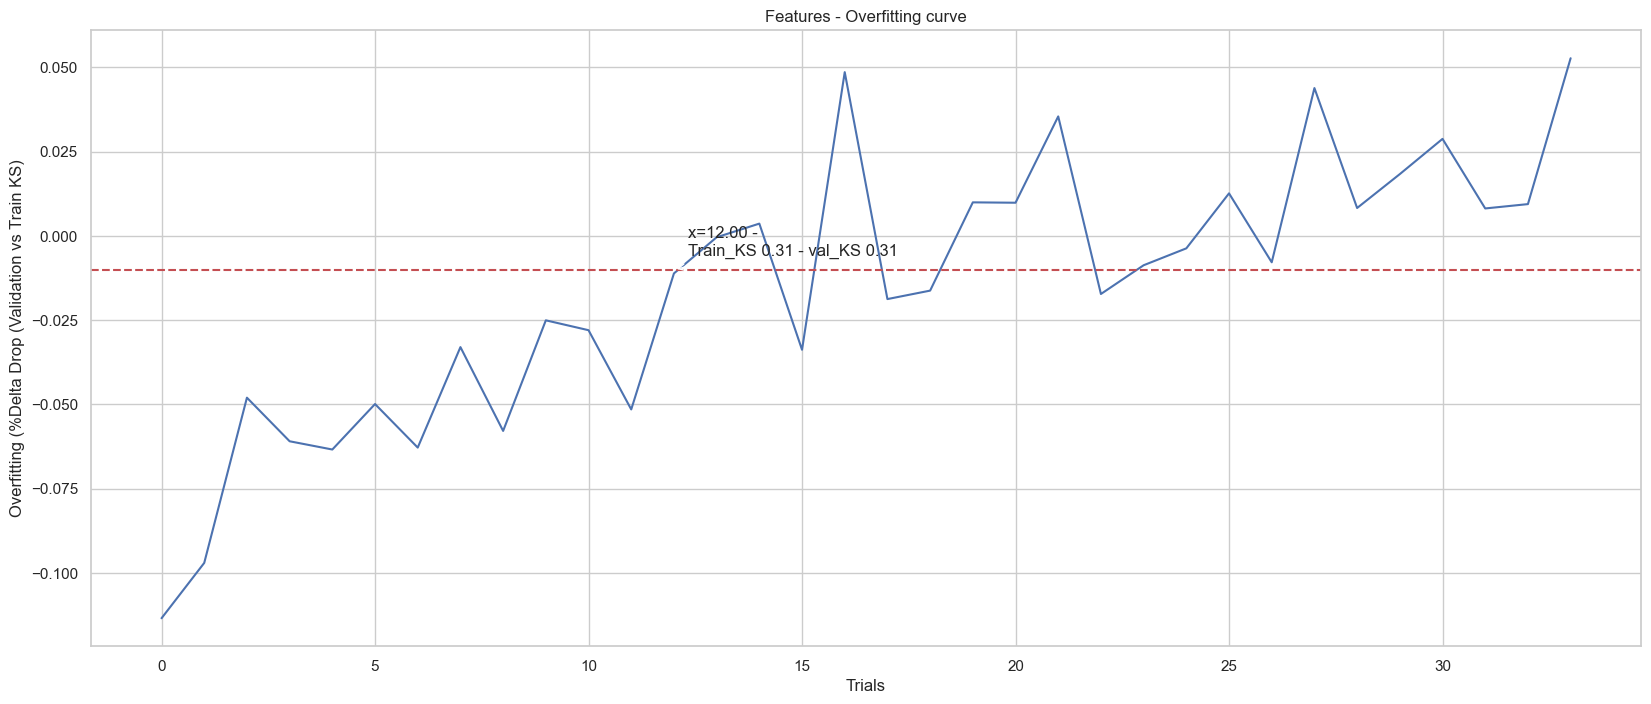

In [203]:
overfitting = -0.01 #-0.11
ax = result_df[['user_attrs_train_ks','user_attrs_val_ks']].apply(lambda x:(x[1]-x[0])/x[0], axis=1).plot(title = 'Features - Overfitting curve',
                                                                                                         xlabel = 'Trials', ylabel = 'Overfitting (%Delta Drop (Validation vs Train KS)')
ax.axhline(y=overfitting, color='r', linestyle='--')

# Find x coordinate where y = -0.08 
x_coord = ax.lines[0].get_xdata()[np.abs(ax.lines[0].get_ydata() - (overfitting)).argmin()]
t_ks = result_df.iloc[x_coord, -3]
v_ks = result_df.iloc[x_coord, -2]

# Add annotation
ax.annotate(f'x={x_coord:.2f} - \nTrain_KS {t_ks:.2f} - val_KS {v_ks:.2f}', xy=(x_coord, overfitting), xytext=(10, 10),
           textcoords='offset points', ha='left',
           arrowprops=dict(arrowstyle='->'));

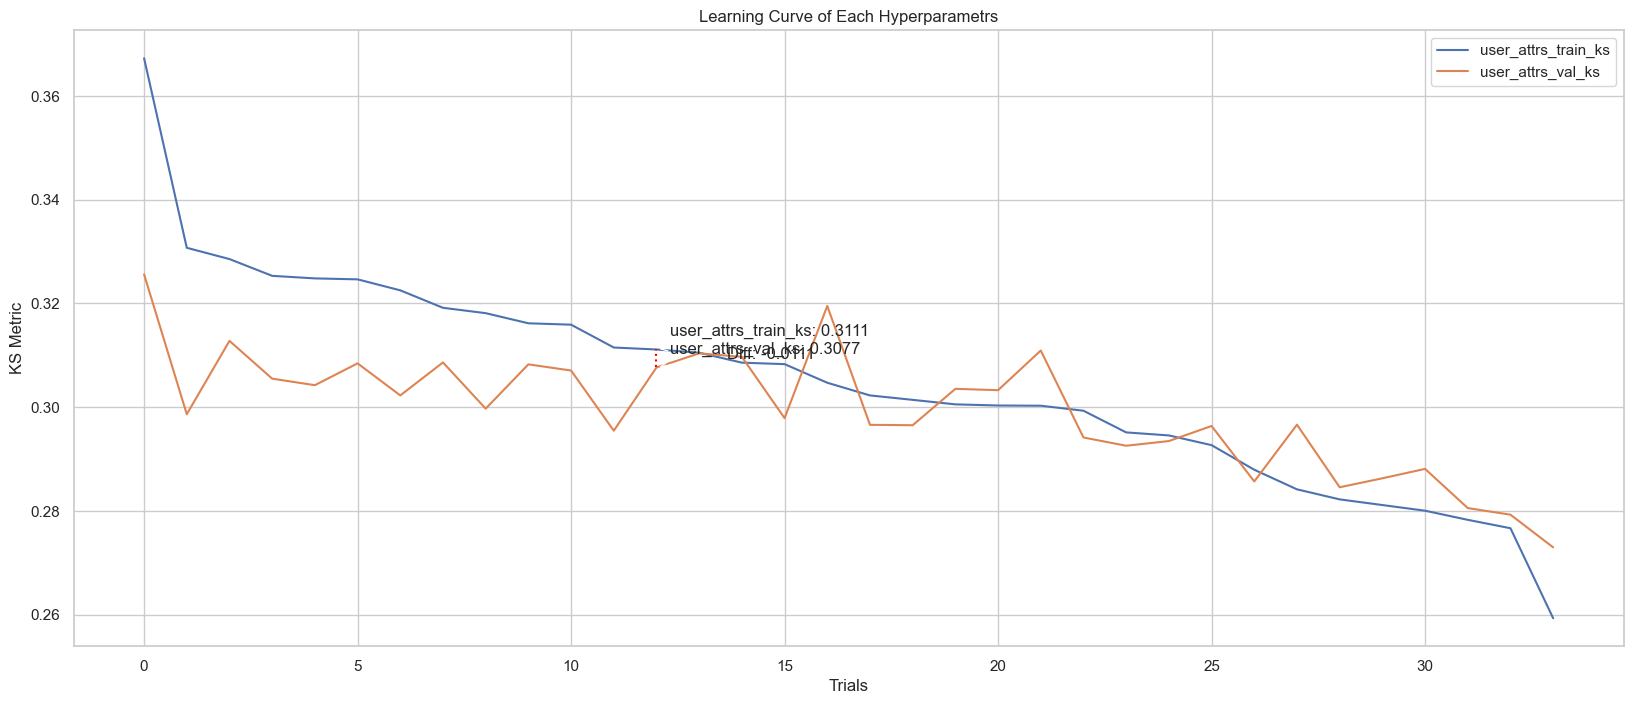

In [204]:
ax = result_df[['user_attrs_train_ks','user_attrs_val_ks']].plot(title = 'Learning Curve of Each Hyperparametrs',
                                                                 xlabel = 'Trials', ylabel = 'KS Metric')

# Get values at iteration value derived above
cols = result_df.columns[result_df.columns.str.contains('user_attrs.*ks|ks.*user_attrs', regex=True)]
val1 = result_df[cols[0]][x_coord]
val2 = result_df[cols[1]][x_coord]

# Annotate individual values
for col, val in zip(cols, [val1, val2]):
   ax.annotate(f'{col}: {val:.4f}', xy=(x_coord, val), xytext=(10, 10),
               textcoords='offset points', ha='left',
               arrowprops=dict(arrowstyle='->'))

# Add vertical dotted line connecting points
ax.vlines(x=x_coord, ymin=min(val1, val2), ymax=max(val1, val2), 
         linestyles=':', color='red')

# Annotate difference
diff = (val2 - val1) / val1
mid_y = (val1 + val2) / 2
ax.annotate(f'Diff: {diff:.4f}', xy=(x_coord+5, mid_y), xytext=(-40, 0),
           textcoords='offset points', ha='right');

In [205]:
result_df.iloc[x_coord]

number                                                                           26
value                                                                       0.30423
datetime_start                                           2025-10-21 23:33:17.971686
datetime_complete                                        2025-10-21 23:33:20.225781
duration                                                     0 days 00:00:02.254095
params_colsample_bytree                                                     0.47526
params_gamma                                                                0.31887
params_learning_rate                                                        0.02279
params_max_bin                                                                   64
params_max_depth                                                                  4
params_max_leaves                                                                11
params_min_child_weight                                                     

In [252]:
final_params = result_df.iloc[x_coord]['user_attrs_hyper_parameters']
final_params['n_estimators'] = int(result_df.iloc[x_coord]['user_attrs_actual_n_estimators'])

In [253]:
final_params

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.47526337914154637,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.31887479015280146,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.022793258860292903,
 'max_bin': 64,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': 11,
 'min_child_weight': 9,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 11,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': 2.5455599955923556,
 'reg_lambda': 0.9275485554284074,
 'sampling_method': None,
 'scale_pos_weight': 4.340528742609555,
 'subsample': 0.4517573152188496,
 'tree_method': 'hist',


In [243]:
result_df.iloc[x_coord]['user_attrs_train_ks'], result_df.iloc[x_coord]['user_attrs_val_ks']

(0.3111137063954794, 0.3076507097980391)

* We selected the best hyperparamters that yielded a stable model

## Final Model Pipeline

In [244]:
len(features)

23

In [245]:
from Local_Model import NullImputa, XGBoostClassifierWithEarlyStoppingNoCV

X_train, X_val = df.loc[df.PARTITION == 'T', features], df.loc[df.PARTITION == 'V', features]
y_train, y_val = df.loc[df.PARTITION == 'T', target], df.loc[df.PARTITION == 'V', target]

numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()  
categorical_cols = X_train.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()  
# Create a preprocessor for numerical columns  
numeric_transformer = Pipeline(steps=[  
    ('custome-imputer', NullImputa(min_count_na = 5, missing_indicator=False)),
])  

# Create a preprocessor for categorical columns  
categorical_transformer = Pipeline(steps=[  
    ('custome-imputer', NullImputa(min_count_na = 5, missing_indicator=False)),  
    ('target_encoder', ce.TargetEncoder(drop_invariant=True))])  
 
# Combine the preprocessors using a ColumnTransformer  
preprocessor = ColumnTransformer(  
    transformers=[  
        ('num', numeric_transformer, numerical_cols),  
        ('cat', categorical_transformer, categorical_cols)])  
  
# Create a pipeline that combines the preprocessor with the estimator  
pipeline = Pipeline(steps=[('preprocessor', preprocessor),  
                           ('classifier', XGBoostClassifierWithEarlyStoppingNoCV(
                               **final_params)
                           )
                          ]) 

In [246]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('custome-imputer',
                                                                   <Local_Model.imputation.NullImputa object at 0x000002A2F3843910>)]),
                                                  ['BalanceMin',
                                                   'BalanceAbove100L30Count',
                                                   'IsNameBased',
                                                   'HasEmpowerBanking',
                                                   'LastRepaymentAmount',
                                                   'SavingsAccountCount',
                                                   'CheckingAccountCount',
                                                   'TotalHistoryInDays',
                                                   'Paycheck', 'Total...
                                                        grow_policy=None,
                                                        importance_type=None,
                                                        interaction_constraints=None,
                                                        learning_rate=0.022793258860292903,
                                                        max_bin=64,
                                                        max_cat_threshold=None,
                                                        max_cat_to_onehot=None,
                                                        max_delta_step=None,
                                                        max_depth=4,
                                                        max_leaves=11,
                                                        min_child_weight=9,
                                                        missing=nan,
                                                        monotone_constraints=None,
                                                        n_estimators=11,
                                                        n_jobs=None,
                                                        num_parallel_tree=None,
                                                        objective='binary:logistic',
                                                        predictor=None, ...))])

In [247]:
pipeline.fit(X_train, y_train)

Imputation complete.....
Imputation complete.....
[23:58:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical", "missing" } are not used.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('custome-imputer',
                                                                   <Local_Model.imputation.NullImputa object at 0x000002A2F3843910>)]),
                                                  ['BalanceMin',
                                                   'BalanceAbove100L30Count',
                                                   'IsNameBased',
                                                   'HasEmpowerBanking',
                                                   'LastRepaymentAmount',
                                                   'SavingsAccountCount',
                                                   'CheckingAccountCount',
                                                   'TotalHistoryInDays',
                                                   'Paycheck', 'Total...
                                                        grow_policy=None,
                                                        importance_type=None,
                                                        interaction_constraints=None,
                                                        learning_rate=0.022793258860292903,
                                                        max_bin=64,
                                                        max_cat_threshold=None,
                                                        max_cat_to_onehot=None,
                                                        max_delta_step=None,
                                                        max_depth=4,
                                                        max_leaves=11,
                                                        min_child_weight=9,
                                                        missing=nan,
                                                        monotone_constraints=None,
                                                        n_estimators=11,
                                                        n_jobs=None,
                                                        num_parallel_tree=None,
                                                        objective='binary:logistic',
                                                        predictor=None, ...))])

In [248]:
y_pred = pipeline.predict_proba(df[features])

Imputation complete.....
Imputation complete.....


In [249]:
df['CASH_ADV_MODEL'] = y_pred[:,1]

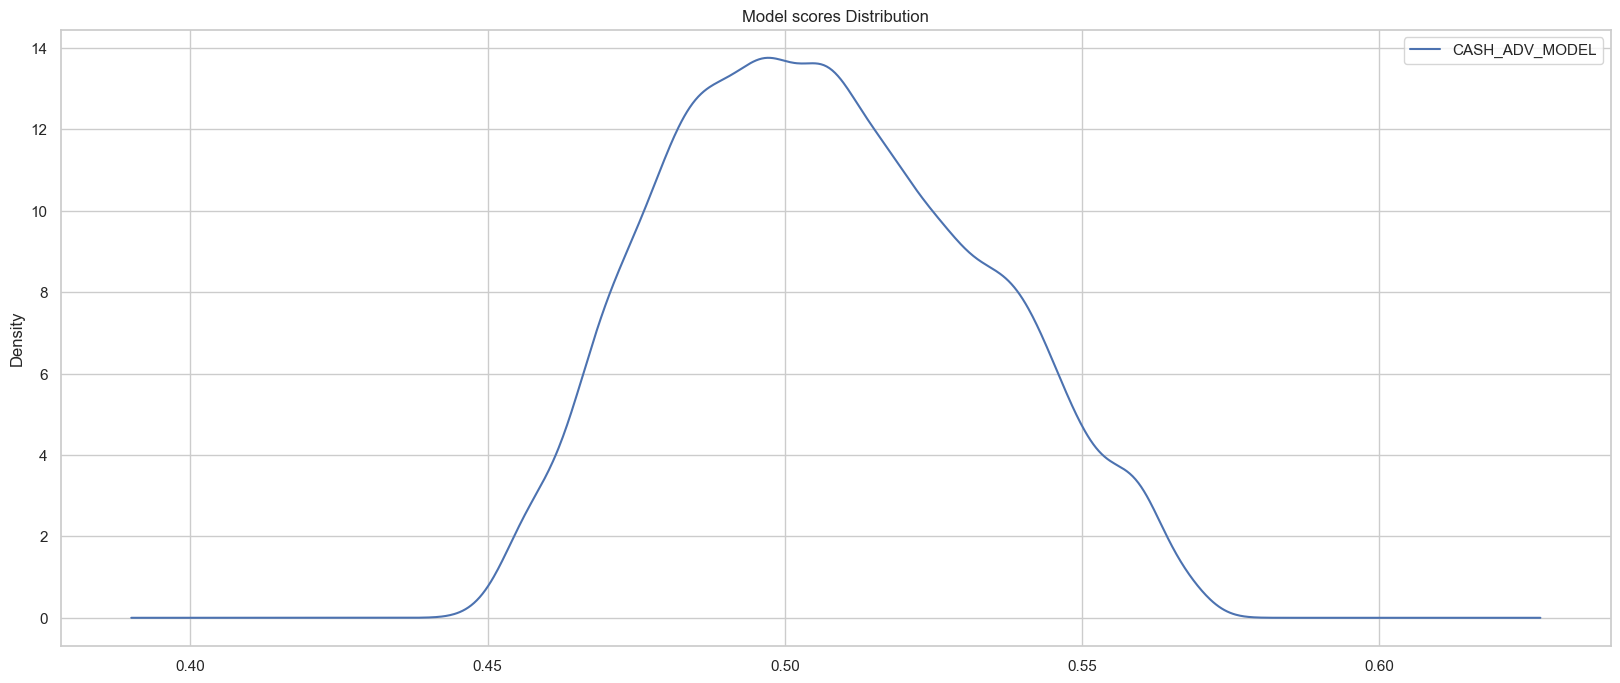

In [255]:
df[['CASH_ADV_MODEL']].plot(kind = 'kde', title = 'Model scores Distribution');

In [250]:
scores = ['CASH_ADV_MODEL']
pds = target
metrics_results = pd.concat([df.groupby(['PARTITION']).apply(
    lambda x : ks_point_estimate(x[pds],x[cols])) for cols in scores], axis = 1)
metrics_results.columns = [i+'_KS' for i in scores]

# Use the scores themselves as the first level
metrics_results.columns = pd.MultiIndex.from_product([[''],metrics_results.columns], 
                                                    names=['Score', 'Metric'])
value_counts = df['PARTITION'].value_counts(normalize = 0).to_frame('Percent_Counts_per_Partition')
value_counts.columns = pd.MultiIndex.from_product([[''],value_counts.columns], names = ['Score', 'Target'])

target_mean = df.groupby(['PARTITION'])[target].mean().to_frame('Target_Mean')
target_mean.columns = pd.MultiIndex.from_product([[''],target_mean.columns], names = ['Score', 'Target'])

final_ks_df = metrics_results.join(value_counts).join(target_mean)
# final_ks_df.style.set_table_attributes("style='display:inline'").set_caption('Production: July&Aug 2023')

final_ks_df.columns = final_ks_df.columns.droplevel(0)

final_ks_df.columns.name = ''

In [251]:
final_ks_df

,CASH_ADV_MODEL_KS,Percent_Counts_per_Partition,Target_Mean
PARTITION,,,
T,0.31539,8265,0.22795
V,0.29089,3543,0.22777


In [254]:
def ks_stat(y_pred, y_true)-> Tuple[str, float]: 
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)  
    ks_stat = max(tpr - fpr)  
    return 'ks_stat', ks_stat

ks_stat(y_pred[:,1], df[target].values)

('ks_stat', 0.3055910473396202)

In [281]:
slicing_columns = ['PARTITION']
scores_list = ['CASH_ADV_MODEL']
target_name = target
for slice_ in slicing_columns:
    print(slice_)
    temp = df.loc[:,
                  scores_list + slicing_columns + [target]] 


    results_auc = temp.groupby([slice_]).apply(metrics_slices_auc_, scores=scores_list)  
    overall_auc = pd.concat([
        pd.DataFrame(metrics_slices_auc(temp.loc[:], score = cols), columns = ['OVERALL']).T for cols in scores_list], 
        axis = 1).T.drop_duplicates().T
    results_auc = pd.concat([overall_auc, results_auc], axis = 0)

    results_ks = temp.groupby([slice_]).apply(metrics_slices_ks_, scores=scores_list)  
    overall_ks = pd.concat([
        pd.DataFrame(metrics_slices_ks(temp.loc[:], score = cols), columns = ['OVERALL']).T for cols in scores_list], 
        axis = 1).T.drop_duplicates().T
    results_ks = pd.concat([overall_ks, results_ks], axis = 0)

PARTITION


In [282]:
results_ks

,Observations,Inter_GRP_BadRate,Sample_Pct_Size,CASH_ADV_MODEL KS
OVERALL,11808.00000,0.22790,1.00000,0.30560
T,8265.00000,0.22790,0.69990,0.31540
V,3543.00000,0.22780,0.30010,0.29090


In [283]:
results_auc

,Observations,Inter_GRP_BadRate,Sample_Pct_Size,CASH_ADV_MODEL AUC
OVERALL,11808.00000,0.22790,1.00000,0.70740
T,8265.00000,0.22790,0.69990,0.71320
V,3543.00000,0.22780,0.30010,0.69380


* A model is as good as its benchmark, but the results look good

In [285]:
gains = gainsTable_non_proba(df['CASH_ADV_MODEL'], df[target_name])
gains = pd.concat([gains.iloc[:-1].sort_values('Interval_Rate', ascending = 1, ) , gains.iloc[[-1]]], axis = 0)
gains

,Score_Range,Count,% Total,Cuml. % Total,Interval_Rate,Events,% Events,Cuml. % Events,Non_Events,% Non_Events,Cuml. % Non_Events,Mid_Point,KS
0,"(-inf, 0.473]",1183,0.10019,0.10019,0.06424,76,0.02824,0.02824,1107,0.12142,0.12142,0.46665,0.09318
1,"(0.473, 0.483]",1179,0.09985,0.20003,0.08482,100,0.03716,0.06540,1079,0.11835,0.23977,0.47800,0.17437
2,"(0.483, 0.49]",1181,0.10002,0.30005,0.12786,151,0.05611,0.12152,1030,0.11298,0.35275,0.48631,0.23123
3,"(0.49, 0.497]",1183,0.10019,0.40024,0.14962,177,0.06577,0.18729,1006,0.11034,0.46309,0.49376,0.27580
4,"(0.497, 0.505]",1178,0.09976,0.50000,0.20628,243,0.09030,0.27759,935,0.10256,0.56565,0.50089,0.28805
5,"(0.505, 0.512]",1182,0.10010,0.60010,0.20728,245,0.09104,0.36864,937,0.10278,0.66842,0.50824,0.29979
6,"(0.512, 0.52]",1179,0.09985,0.69995,0.25106,296,0.11000,0.47863,883,0.09685,0.76527,0.51619,0.28664
7,"(0.52, 0.531]",1181,0.10002,0.79997,0.31499,372,0.13824,0.61687,809,0.08874,0.85401,0.52543,0.23714
8,"(0.531, 0.543]",1183,0.10019,0.90015,0.37025,438,0.16276,0.77964,745,0.08172,0.93572,0.53663,0.15609
9,"(0.543, inf]",1179,0.09985,1.00000,0.50297,593,0.22036,1.00000,586,0.06428,1.00000,0.55174,0.00000


In [289]:
q = 10

# Create quantile bands without grouping
fd = df[['CASH_ADV_MODEL']].dropna(axis=1).apply(
    lambda col: pd.qcut(col.rank(method='first'), q=q, labels=range(q,0,-1))
    if col.max() > 1 else pd.qcut(col.rank(method='first'), q=q, labels=range(1,q+1))
)

columns = list(fd.columns)
fd = pd.concat([df[target_name], fd], axis=1)

# Calculate mean target by bands for each score
band_means = pd.concat([fd.groupby(x)[target_name].mean().fillna(0) for x in columns], 
                       axis=1, keys=columns)

In [290]:
band_means

,CASH_ADV_MODEL
CASH_ADV_MODEL,
1,0.06266
2,0.08637
3,0.12786
4,0.15000
5,0.20576
6,0.20660
7,0.25169
8,0.31499
9,0.36918


* The model rank orders perfectly ith a small hiccup beween bin 5 and 6

## Feature Importance

In [267]:
preprocessor = pipeline.named_steps['preprocessor']  
numeric_column_names_after_preprocessing = preprocessor.transformers_[0][1].named_steps['custome-imputer'].column_names  

# Get the original categorical column names from the imputer
categorical_column_names_from_imputer = preprocessor.transformers_[1][1].named_steps['custome-imputer'].column_names  

# Get the actual feature names after target encoding (accounting for dropped columns)
target_encoder = preprocessor.transformers_[1][1].named_steps['target_encoder']
if hasattr(target_encoder, 'feature_names_out_'):
    categorical_column_names_after_preprocessing = target_encoder.feature_names_out_
elif hasattr(target_encoder, 'get_feature_names_out'):
    try:
        categorical_column_names_after_preprocessing = target_encoder.get_feature_names_out(categorical_column_names_from_imputer)
    except:
        # Fallback: assume columns that weren't dropped
        categorical_column_names_after_preprocessing = [col for col in categorical_column_names_from_imputer 
                                                      if col not in getattr(target_encoder, 'invariant_cols_', [])]
else:
    # Manual check for invariant columns
    categorical_column_names_after_preprocessing = categorical_column_names_from_imputer

if categorical_column_names_after_preprocessing:
    features_after_preprocessing = numeric_column_names_after_preprocessing + list(categorical_column_names_after_preprocessing)
else:
    features_after_preprocessing = numeric_column_names_after_preprocessing

In [268]:
importances = pipeline.named_steps['classifier'].bst.get_score(importance_type='gain')  

preprocessor = pipeline.named_steps['preprocessor']  

numeric_column_names_after_preprocessing = preprocessor.transformers_[0][1].named_steps['custome-imputer'].column_names  
categorical_column_names_after_preprocessing = preprocessor.transformers_[1][1].named_steps['custome-imputer'].column_names  

if categorical_column_names_after_preprocessing:
    features_after_preprocessing = numeric_column_names_after_preprocessing + categorical_column_names_after_preprocessing
else:
    features_after_preprocessing = numeric_column_names_after_preprocessing

# Map to actual feature names  
# importances_with_feat_names = {features_after_preprocessing[int(feat[1:])]: imp for feat, imp in importances.items()}  
print("Number of features after preprocessing:", len(features_after_preprocessing))  
print("Max feature index in importances:", max(int(feat[1:]) for feat in importances.keys()))

features_order = [f'f{i}' for i in range(len(features_after_preprocessing))]
mapper = dict(zip(features_order,features_after_preprocessing))
importances = pipeline.named_steps['classifier'].bst.get_score(importance_type='gain') 
importances = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])  

importances['Feature'] = importances['Feature'].map(mapper)

importances['Normalized_Importance'] = importances['Importance'] / importances['Importance'].sum()
# Sort the DataFrame by importance  
importances = importances.sort_values(by='Normalized_Importance', ascending=False)  

Number of features after preprocessing: 23
Max feature index in importances: 19


In [269]:
importances.shape

(17, 3)

In [311]:
importances

,Feature,Importance,Normalized_Importance
9,BalanceAverage,150.01303,0.19171
14,OverdraftTotal,86.70040,0.11080
10,AverageMonthlyDiscretionarySpend,77.64581,0.09923
11,NegativeBalanceCount,61.96863,0.07919
13,AverageMonthlySpend,61.89906,0.07910
8,CurrentBalance,55.48706,0.07091
1,BalanceAbove100L30Count,37.50082,0.04792
6,Paycheck,36.53538,0.04669
12,AverageNumberOfTransactionsADayPrimaryChecking,35.97670,0.04598
5,TotalHistoryInDays,32.58902,0.04165


In [272]:
len(pipeline.named_steps['classifier'].bst.get_score(importance_type='gain') )

17

In [314]:
features - set(importances['Feature'].to_list())

{'ErrorRate',
 'HasEmpowerBanking',
 'IsNameBased',
 'LatefeesCount',
 'LatefeesTotalCount',
 'PaycheckModelUsed'}

* There are 5 features with zero importance, these need to be dropped then refit the model again

In [348]:
def quantile_1(x): 
    return x.quantile(.01)
def quantile_5(x): 
    return x.quantile(.05)
def quantile_95(x): 
    return x.quantile(.95)
def quantile_99(x): 
    return x.quantile(.99)
def stats_sheet(dataset):
    # New_Refit_routing = New_Refit_routing.set_index("app_name")
    stats = dataset.describe().T.copy()
    stats["Missing_Values(%)"] = (dataset.isna().sum() / len(dataset)) * 100
    stats = stats.drop(columns = 'count')
    stats['percentile_1'] = dataset.apply(quantile_1)
    stats['percentile_5'] = dataset.apply(quantile_5)
    stats['percentile_95'] = dataset.apply(quantile_95)
    stats['percentile_99'] = dataset.apply(quantile_99)
    print(stats.shape)
    return stats

In [349]:
stats_df = stats_sheet(df[importances['Feature'].to_list()])
stats_df

(17, 12)


,mean,std,min,25%,50%,75%,max,Missing_Values(%),percentile_1,percentile_5,percentile_95,percentile_99
BalanceAverage,418.37462,12496.39021,-888820.57000,147.54500,286.38500,535.68750,878155.10000,0.00000,-271.94000,18.94150,1490.62000,3311.37210
OverdraftTotal,6.89312,20.09222,0.00000,0.00000,0.00000,5.00000,536.00000,0.00000,0.00000,0.00000,34.00000,89.93000
AverageMonthlyDiscretionarySpend,-1009.14216,925.19852,-18008.59000,-1322.25083,-809.04167,-445.98333,12699.51667,0.00000,-4185.64477,-2658.12250,-96.71383,359.48130
NegativeBalanceCount,8.18098,9.37777,0.00000,0.00000,4.00000,14.00000,63.00000,0.00000,0.00000,0.00000,28.00000,35.00000
AverageMonthlySpend,-3741.36347,2648.07591,-79863.13060,-4604.76615,-3191.04387,-2172.37003,-28.22249,0.00000,-12962.38917,-7995.71767,-1074.16999,-558.52261
CurrentBalance,133.14083,427.86386,-987.56000,0.06000,11.72500,114.33250,19002.09000,25.91463,-99.36000,-49.87950,718.20750,1507.97600
BalanceAbove100L30Count,10.14964,9.64930,0.00000,0.00000,9.00000,18.00000,38.00000,0.00000,0.00000,0.00000,28.00000,30.00000
Paycheck,2292.25343,1385.02951,501.78556,1492.41764,2015.94333,2708.36583,31002.11111,0.00000,650.00000,965.11064,4506.70172,7058.21727
AverageNumberOfTransactionsADayPrimaryChecking,3.16164,1.52362,0.30387,2.10599,2.93922,3.95622,18.04636,0.00000,0.63670,1.11634,5.97974,7.95961
TotalHistoryInDays,454.87375,326.86798,60.02681,175.78387,436.92605,634.45358,2621.96269,0.00000,62.79616,80.29400,1010.79659,1564.53988


In [350]:
importances.merge(stats_df.reset_index(names = 'Feature'))# Final Reporting

,Feature,Importance,Normalized_Importance,mean,std,min,25%,50%,75%,max,Missing_Values(%),percentile_1,percentile_5,percentile_95,percentile_99
0,BalanceAverage,150.01303,0.19171,418.37462,12496.39021,-888820.57000,147.54500,286.38500,535.68750,878155.10000,0.00000,-271.94000,18.94150,1490.62000,3311.37210
1,OverdraftTotal,86.70040,0.11080,6.89312,20.09222,0.00000,0.00000,0.00000,5.00000,536.00000,0.00000,0.00000,0.00000,34.00000,89.93000
2,AverageMonthlyDiscretionarySpend,77.64581,0.09923,-1009.14216,925.19852,-18008.59000,-1322.25083,-809.04167,-445.98333,12699.51667,0.00000,-4185.64477,-2658.12250,-96.71383,359.48130
3,NegativeBalanceCount,61.96863,0.07919,8.18098,9.37777,0.00000,0.00000,4.00000,14.00000,63.00000,0.00000,0.00000,0.00000,28.00000,35.00000
4,AverageMonthlySpend,61.89906,0.07910,-3741.36347,2648.07591,-79863.13060,-4604.76615,-3191.04387,-2172.37003,-28.22249,0.00000,-12962.38917,-7995.71767,-1074.16999,-558.52261
5,CurrentBalance,55.48706,0.07091,133.14083,427.86386,-987.56000,0.06000,11.72500,114.33250,19002.09000,25.91463,-99.36000,-49.87950,718.20750,1507.97600
6,BalanceAbove100L30Count,37.50082,0.04792,10.14964,9.64930,0.00000,0.00000,9.00000,18.00000,38.00000,0.00000,0.00000,0.00000,28.00000,30.00000
7,Paycheck,36.53538,0.04669,2292.25343,1385.02951,501.78556,1492.41764,2015.94333,2708.36583,31002.11111,0.00000,650.00000,965.11064,4506.70172,7058.21727
8,AverageNumberOfTransactionsADayPrimaryChecking,35.97670,0.04598,3.16164,1.52362,0.30387,2.10599,2.93922,3.95622,18.04636,0.00000,0.63670,1.11634,5.97974,7.95961
9,TotalHistoryInDays,32.58902,0.04165,454.87375,326.86798,60.02681,175.78387,436.92605,634.45358,2621.96269,0.00000,62.79616,80.29400,1010.79659,1564.53988


## Partial Dependence Plots
* For Fair Lending concerns, features in the OOT set that have a counter-intuive model score with respect tot he feature value need to be dropped

In [315]:
from tqdm import tqdm
def partial_dependency(bst, X, y, feature_ids = [], f_id = -1, missing_value_impute = -9999999999, bins = 20):

    """
    Calculate the dependency (or partial dependency) of a response variable on a predictor (or multiple predictors)
    1. Sample a grid of values of a predictor.
    2. For each value, replace every row of that predictor with this value, calculate the average prediction.
    """

    X_temp = X.copy()
    #Remove the NaNs imputation from scope
    grid = np.linspace(np.percentile(X_temp.loc[X_temp[X_temp.columns[f_id]] != missing_value_impute, X_temp.columns[f_id]], 0.1),
                       np.percentile(X_temp.loc[X_temp[X_temp.columns[f_id]] != missing_value_impute, X_temp.columns[f_id]], 99.5),
                       bins)
    # grid = np.append(grid, missing_value_impute) #add missing value category
    
    y_pred = np.zeros(len(grid))

    valid_data = X_temp.loc[X_temp[X_temp.columns[f_id]] != missing_value_impute, X_temp.columns[f_id]]
    bin_counts, bin_edges = np.histogram(valid_data, bins=bins)

    # Format bin_edges as intervals
    formatted_bins = []
    for i in range(len(bin_edges) - 1):
        left = f"{bin_edges[i]:.2f}"
        right = f"{bin_edges[i+1]:.2f}"
        formatted_bins.append(f"[ {left}, {right} )")
    print(len(valid_data)), print(len(bin_counts)), print(len(formatted_bins))
    # grid_min, grid_max = grid[0], grid[-1]
    # bin_edges = np.linspace(grid_min, grid_max, bins)  # bins+1 edges for bins intervals
    # bin_counts, bin_edges = np.histogram(valid_data, bins=bin_edges)
    
    if len(feature_ids) == 0 or f_id == -1:
        print('Input error!')
        return
    else:
        for i, val in enumerate(grid):

            X_temp.iloc[:, f_id] = val
            # data = xgb.DMatrix(X_temp.iloc[:, feature_ids])
            data = X_temp.iloc[:, feature_ids]
            # y_pred[i] = np.average(bst.predict(data)['target_1_PREDICTION'])
            y_pred[i] = np.average(bst.predict_proba(data)[:,1])

    return grid, y_pred, bin_counts, formatted_bins

In [317]:
display(df['PARTITION'].unique())
partitions = ['V']

array(['T', 'V'], dtype=object)

In [319]:
feature_names = list(features) #UW6_features

# cols_stage =  [i for i in feature_names for n in stage_features if i.startswith(n)]  
cols_stage = list(features) #UW6_features

data = df.loc[df.PARTITION.isin(partitions), feature_names + [target_name]].replace({"nan":-9999999999, np.nan:-9999999999}).reset_index(drop = True).copy()
feature_ids = [data.columns.get_loc(f) for f in feature_names]

all_PDs = pd.DataFrame()
for f in tqdm(cols_stage):
    # print(f)
    partial_dependency_ploys_df = pd.DataFrame(columns = ["feature", "grid","y_pred"])
    grid, y_pred, bin_counts, bin_edges = partial_dependency(pipeline,
                                      data,
                                      data[[target_name]],
                                      feature_ids = feature_ids,
                                      f_id = feature_names.index(f)
                                     )
   
    partial_dependency_ploys_df["grid"] = grid
    # partial_dependency_ploys_df["grid"] = partial_dependency_ploys_df["grid"].replace({-9999999999:"MISSING"})
    partial_dependency_ploys_df["y_pred"] = y_pred
    partial_dependency_ploys_df["row_counts"] = bin_counts
    partial_dependency_ploys_df["labels"] = bin_edges
    partial_dependency_ploys_df["feature"] = str(f)
    all_PDs = all_PDs.append(partial_dependency_ploys_df)
all_PDs.reset_index(drop = True,inplace=True)

  0%|                                                                                                               | 0/23 [00:00<?, ?it/s]

3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....


  4%|████▍                                                                                                  | 1/23 [00:12<04:30, 12.28s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

  9%|████████▉                                                                                              | 2/23 [00:26<04:39, 13.29s/it]

Imputation complete.....
Imputation complete.....
3453
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 13%|█████████████▍                                                                                         | 3/23 [00:39<04:25, 13.30s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 17%|█████████████████▉                                                                                     | 4/23 [00:53<04:18, 13.61s/it]

3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....


 22%|██████████████████████▍                                                                                | 5/23 [01:06<04:00, 13.34s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 26%|██████████████████████████▊                                                                            | 6/23 [01:19<03:43, 13.12s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 30%|███████████████████████████████▎                                                                       | 7/23 [01:31<03:25, 12.82s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 35%|███████████████████████████████████▊                                                                   | 8/23 [01:43<03:09, 12.63s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 39%|████████████████████████████████████████▎                                                              | 9/23 [01:55<02:54, 12.44s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 43%|████████████████████████████████████████████▎                                                         | 10/23 [02:07<02:40, 12.31s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 48%|████████████████████████████████████████████████▊                                                     | 11/23 [02:20<02:28, 12.42s/it]

Imputation complete.....
Imputation complete.....
2631
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 52%|█████████████████████████████████████████████████████▏                                                | 12/23 [02:33<02:17, 12.53s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 57%|█████████████████████████████████████████████████████████▋                                            | 13/23 [02:45<02:05, 12.58s/it]

Imputation complete.....
Imputation complete.....
3543
20
20
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation complete.....
Imputation com

 61%|██████████████████████████████████████████████████████████████                                        | 14/23 [02:59<01:55, 12.79s/it]

Imputation complete.....
Imputation complete.....


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U10'), dtype('<U10')) -> None

In [330]:
partial_dependence_external = all_PDs.rename(columns={'grid':'label', 'y_pred':'dependence'})

In [331]:
partial_dependence_external.label = partial_dependence_external.label.round(8).astype(str)

In [332]:
partial_dependence_plots = partial_dependence_external.copy()
del partial_dependence_external 

In [341]:
# dictionary['Variable'] = dictionary['Variable'].str.upper()
dictionary['Feature_Definition'] = dictionary['Variable'] + '-' + dictionary['Description']
dictionary.head()

,Variable,Description,Feature_Definition
0,DefaultedAdvances,Target variable - whether or not they repaid t...,DefaultedAdvances-Target variable - whether or...
1,AdvanceAmount,Cash advance amount in dollars,AdvanceAmount-Cash advance amount in dollars
2,CurrentBalance,Balance on the user's primary checking account...,CurrentBalance-Balance on the user's primary c...
3,LatefeesTotalCount,Total number of late fees on external checking...,LatefeesTotalCount-Total number of late fees o...
4,CreditAccounts,Number of credit accounts they've connected to...,CreditAccounts-Number of credit accounts they'...


In [342]:
partial_dependence_plots.head()

,feature,label,dependence,row_counts,labels,feature_name_raw,feature_name
0,BalanceMin,-6252.65356,0.50574,2,"[ -890657.65, -845465.90 )",BalanceMin,NaN
1,BalanceMin,-5888.27666737,0.50574,0,"[ -845465.90, -800274.14 )",BalanceMin,NaN
2,BalanceMin,-5523.89977474,0.50574,0,"[ -800274.14, -755082.39 )",BalanceMin,NaN
3,BalanceMin,-5159.52288211,0.50574,0,"[ -755082.39, -709890.63 )",BalanceMin,NaN
4,BalanceMin,-4795.14598947,0.50574,0,"[ -709890.63, -664698.88 )",BalanceMin,NaN


In [343]:
definition_mapper = dictionary[['Variable','Feature_Definition']].set_index('Variable').to_dict()['Feature_Definition']

partial_dependence_plots['feature_name_raw'] = partial_dependence_plots['feature']
partial_dependence_plots['feature_name'] = partial_dependence_plots['feature'].map(definition_mapper)

partial_dependence_plots.head()

,feature,label,dependence,row_counts,labels,feature_name_raw,feature_name
0,BalanceMin,-6252.65356,0.50574,2,"[ -890657.65, -845465.90 )",BalanceMin,BalanceMin-Minimum all time balance on externa...
1,BalanceMin,-5888.27666737,0.50574,0,"[ -845465.90, -800274.14 )",BalanceMin,BalanceMin-Minimum all time balance on externa...
2,BalanceMin,-5523.89977474,0.50574,0,"[ -800274.14, -755082.39 )",BalanceMin,BalanceMin-Minimum all time balance on externa...
3,BalanceMin,-5159.52288211,0.50574,0,"[ -755082.39, -709890.63 )",BalanceMin,BalanceMin-Minimum all time balance on externa...
4,BalanceMin,-4795.14598947,0.50574,0,"[ -709890.63, -664698.88 )",BalanceMin,BalanceMin-Minimum all time balance on externa...


In [344]:
max_pdp_val = partial_dependence_plots['dependence'].max() + 0.01
min_pdp_val = partial_dependence_plots['dependence'].min() - 0.01

  7%|███████▎                                                                                               | 1/14 [00:00<00:02,  5.30it/s]

BalanceMin


 14%|██████████████▋                                                                                        | 2/14 [00:00<00:02,  5.47it/s]

BalanceAbove100L30Count
IsNameBased


 29%|█████████████████████████████▍                                                                         | 4/14 [00:00<00:01,  5.76it/s]

HasEmpowerBanking
LastRepaymentAmount


 43%|████████████████████████████████████████████▏                                                          | 6/14 [00:01<00:01,  5.97it/s]

SavingsAccountCount
CheckingAccountCount


 57%|██████████████████████████████████████████████████████████▊                                            | 8/14 [00:01<00:01,  5.69it/s]

TotalHistoryInDays
Paycheck


 71%|████████████████████████████████████████████████████████████████████████▊                             | 10/14 [00:01<00:00,  5.99it/s]

TotalAssets
LatefeesCount


 86%|███████████████████████████████████████████████████████████████████████████████████████▍              | 12/14 [00:02<00:00,  5.81it/s]

CurrentBalance
BalanceAverage


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.04it/s]


AverageMonthlyDiscretionarySpend


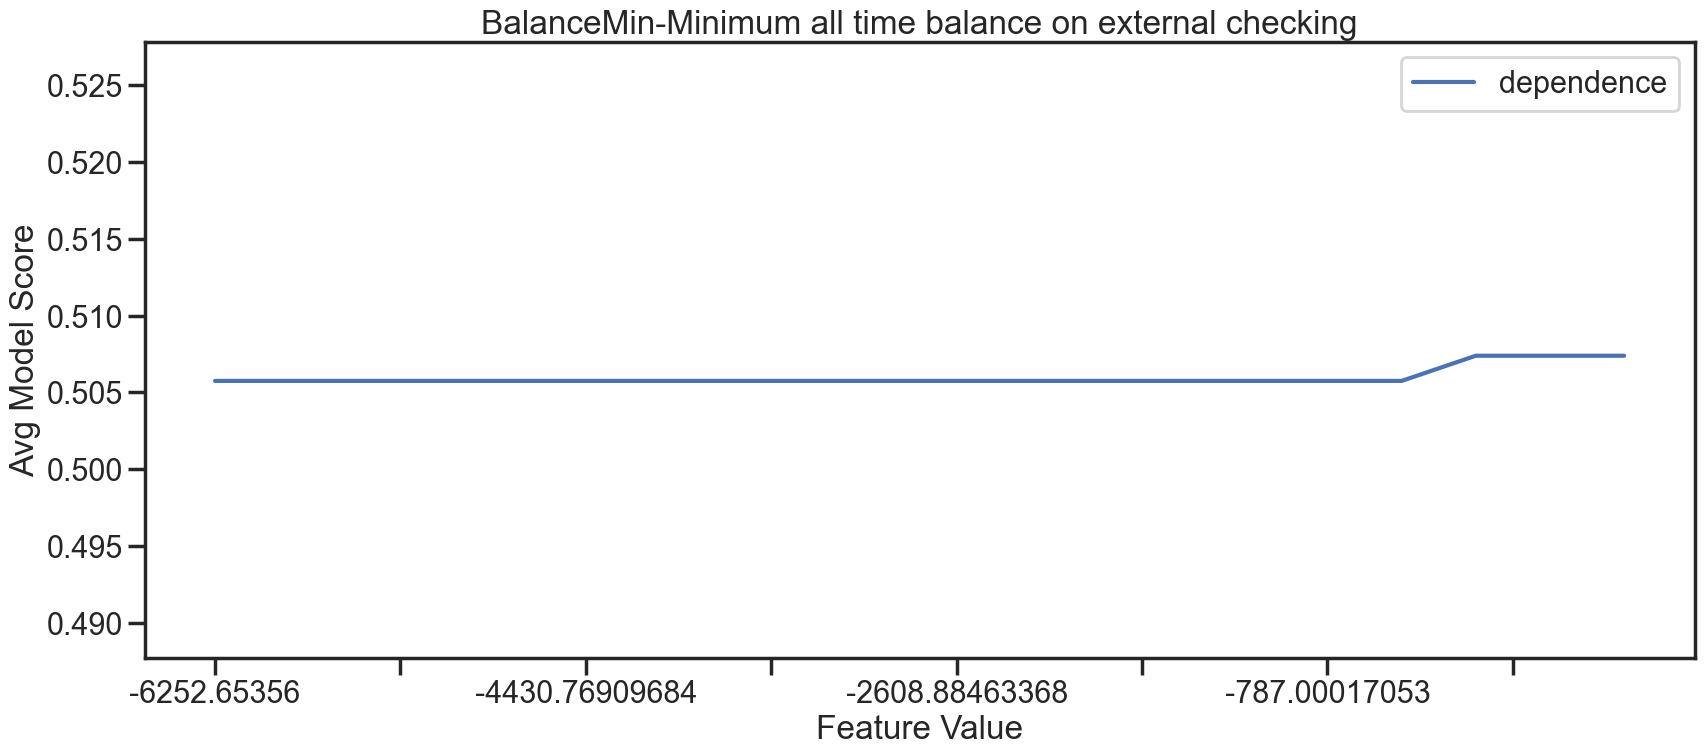

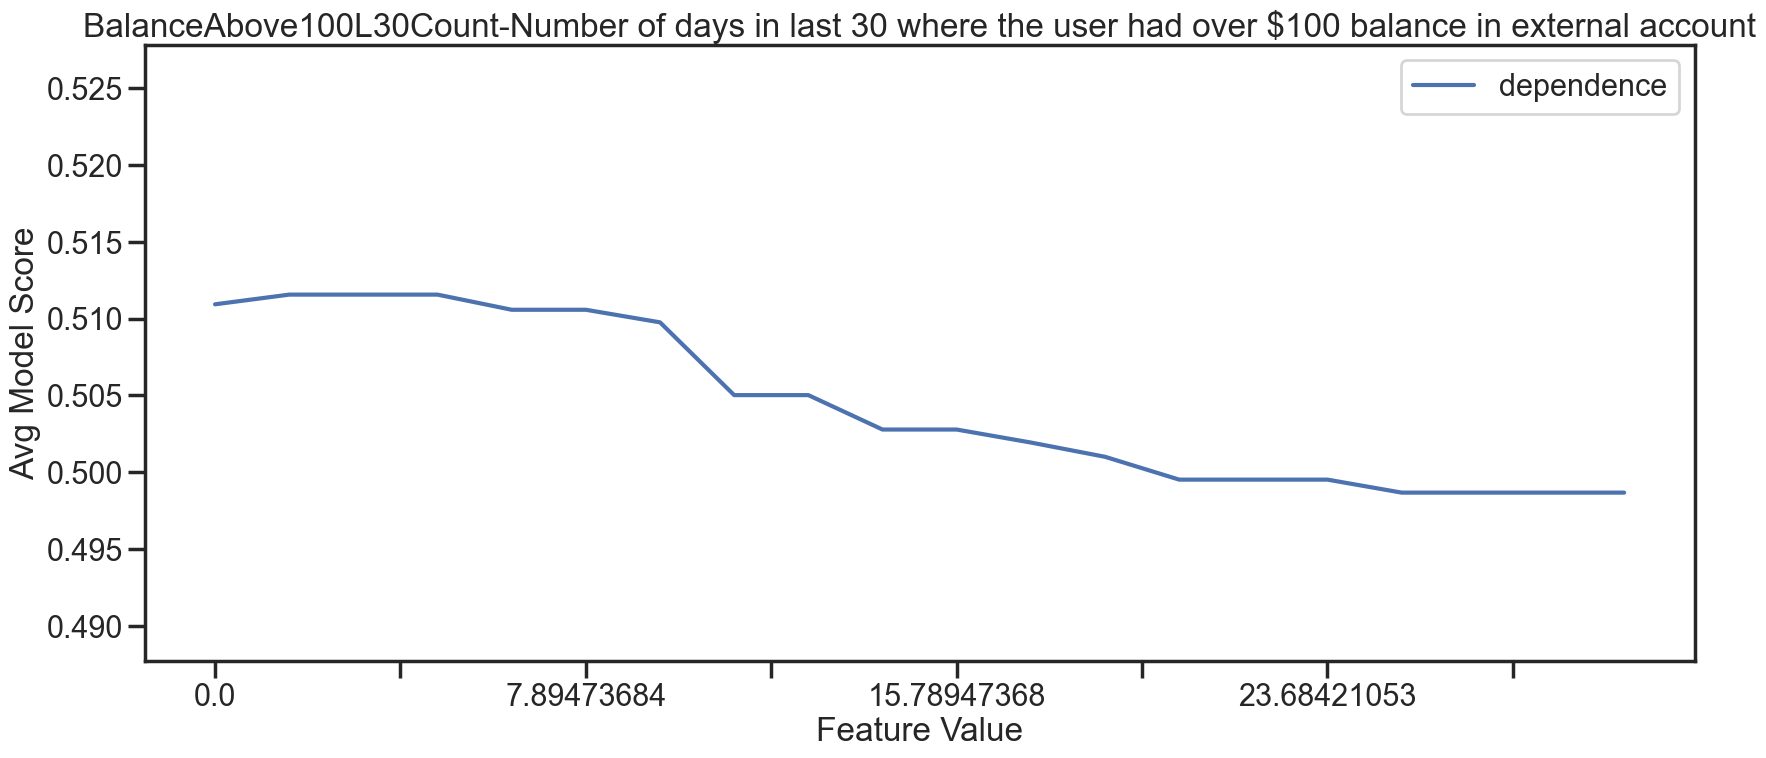

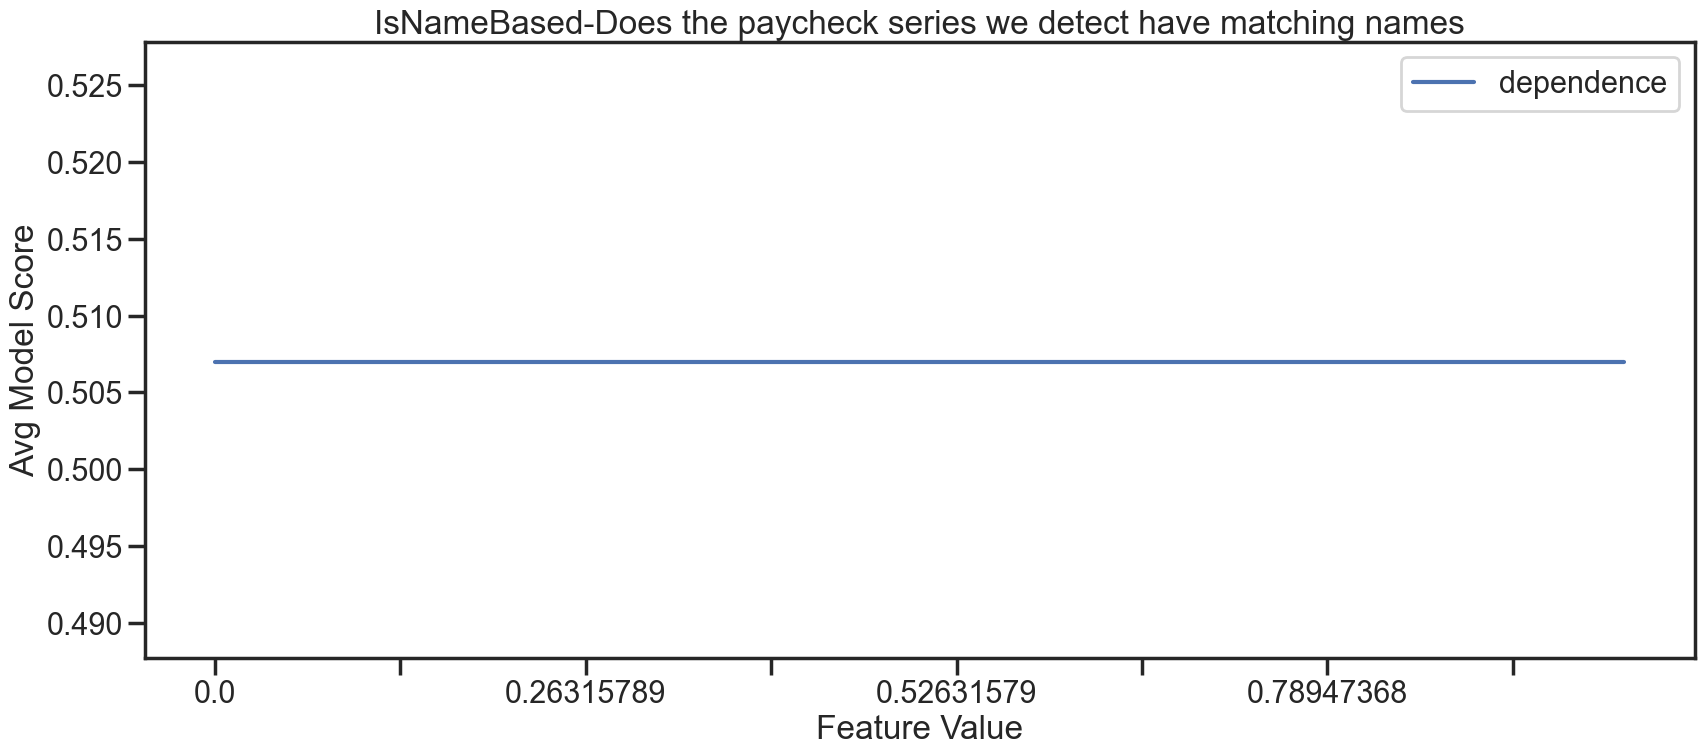

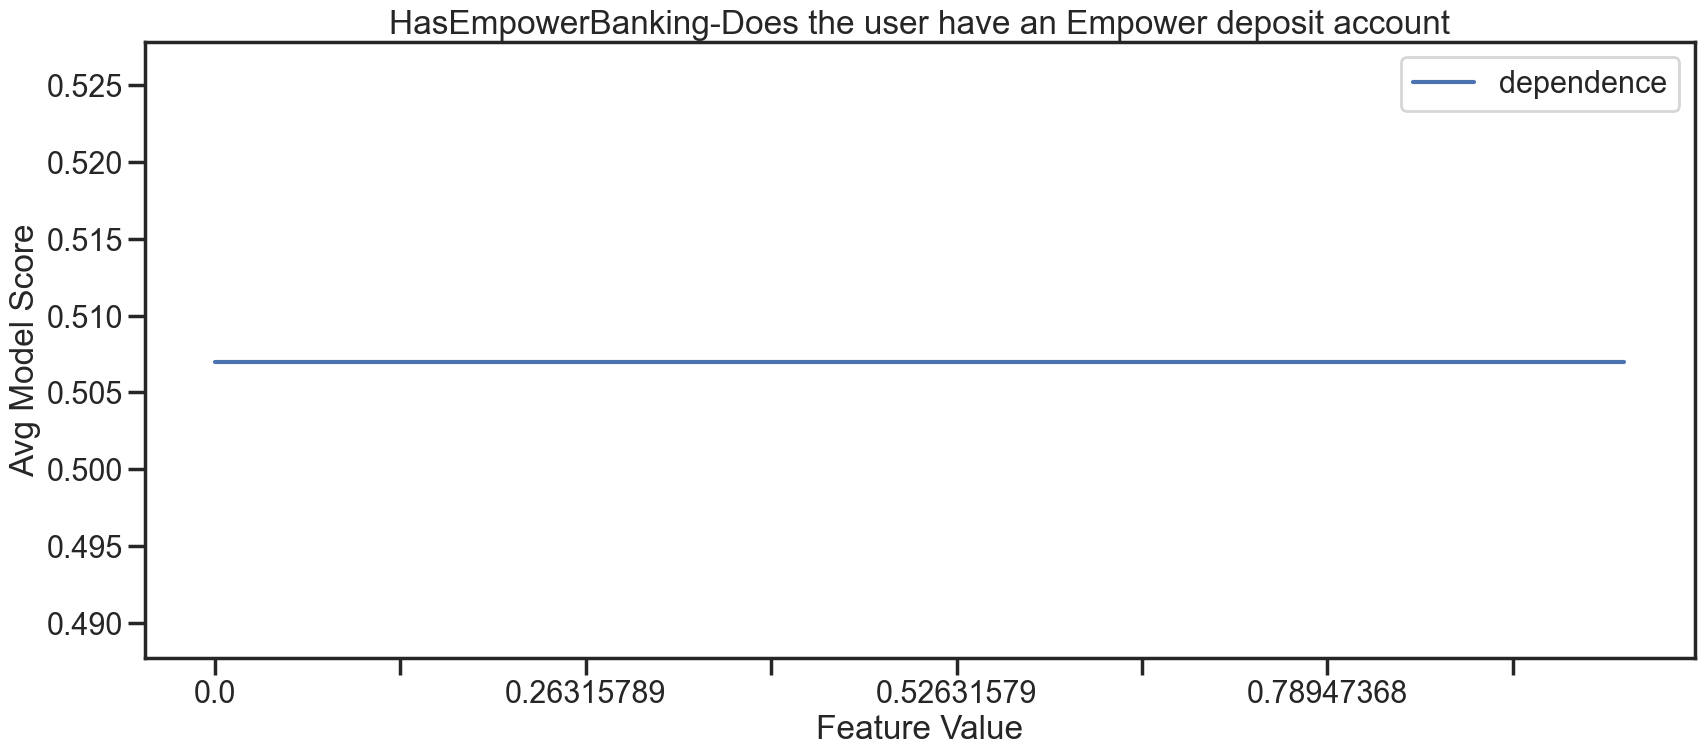

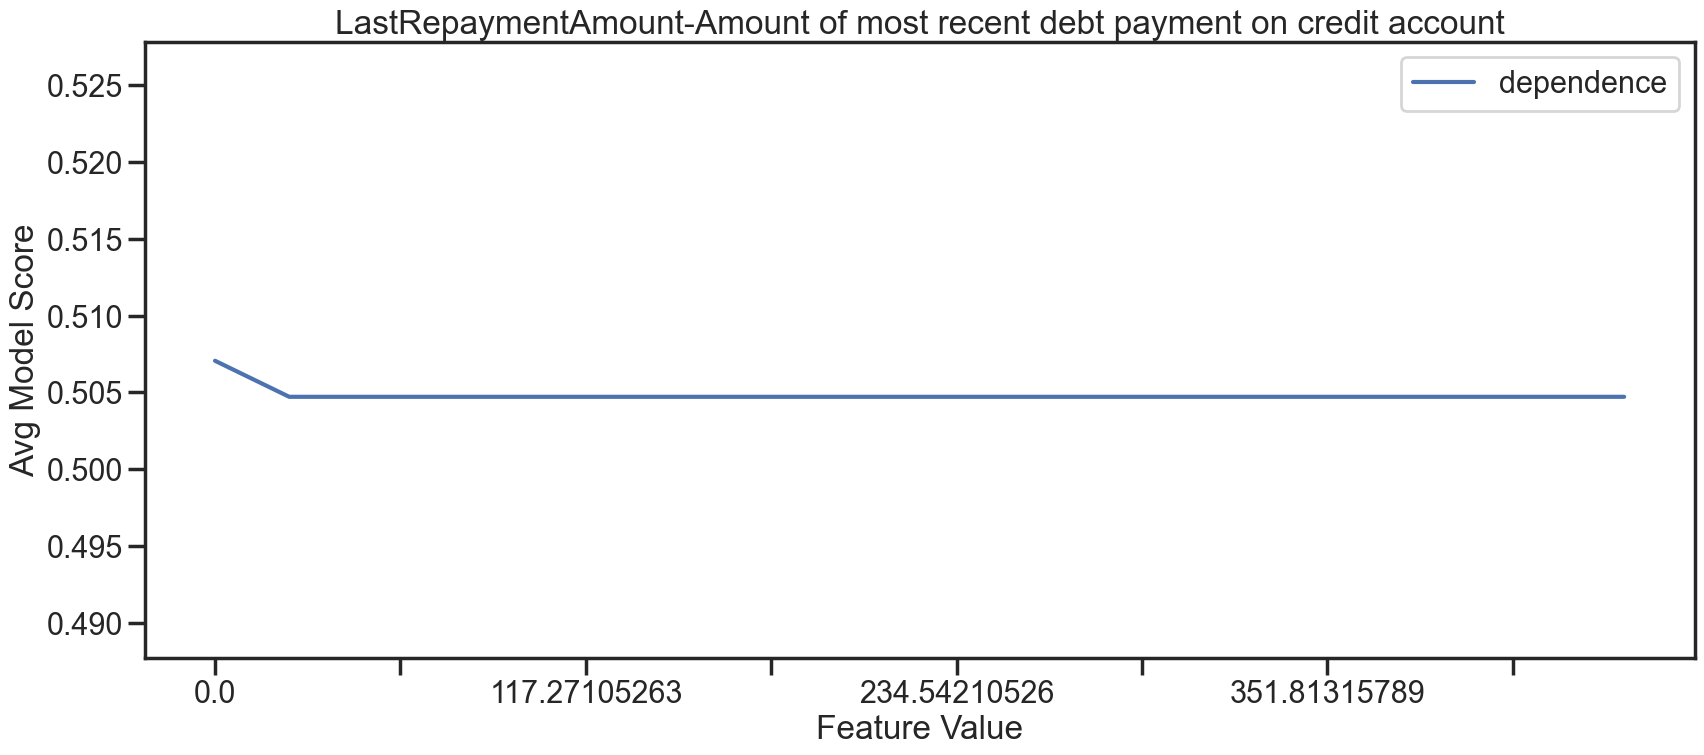

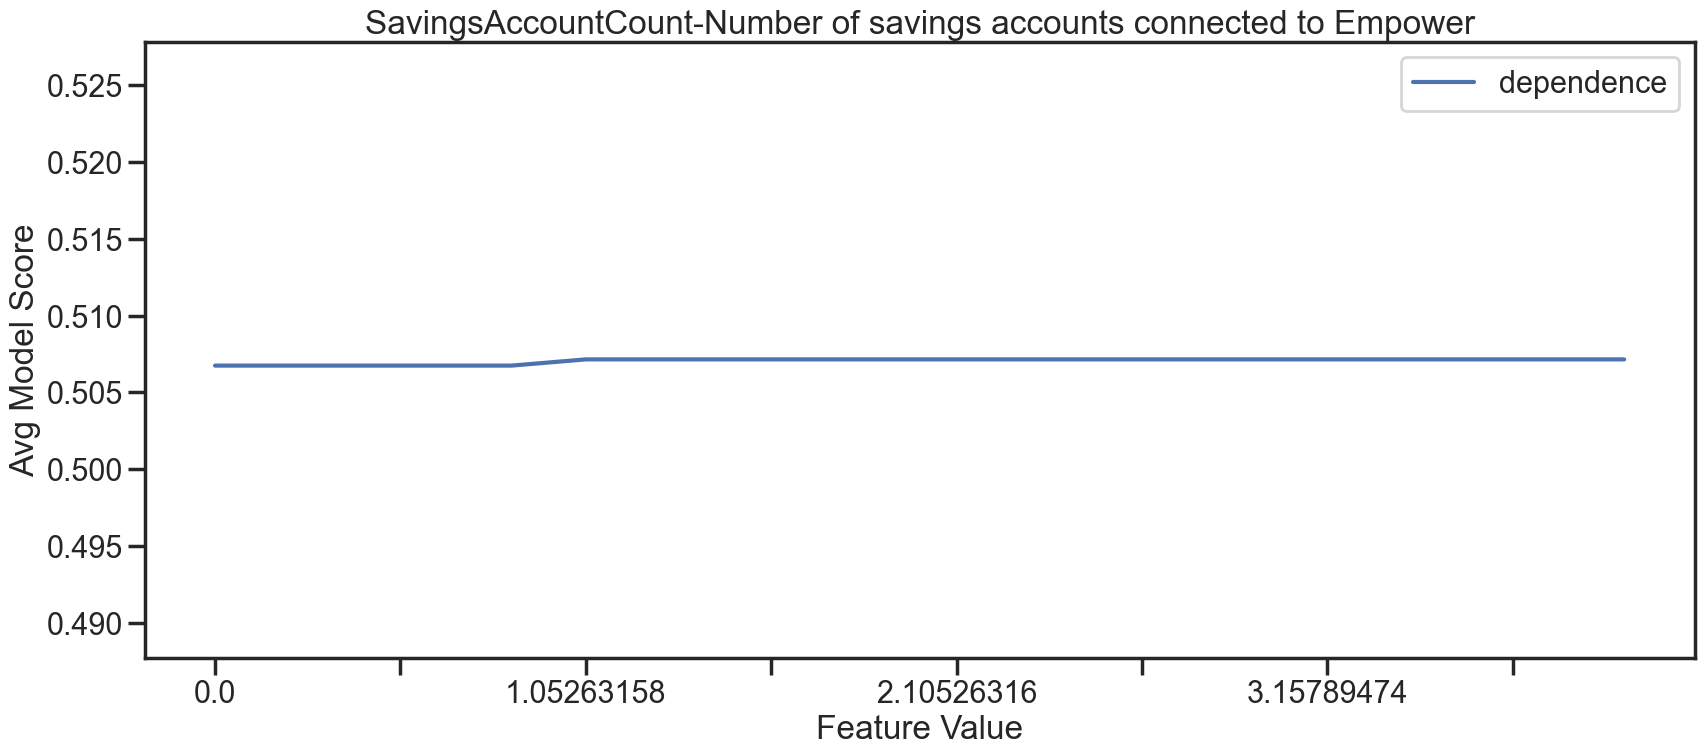

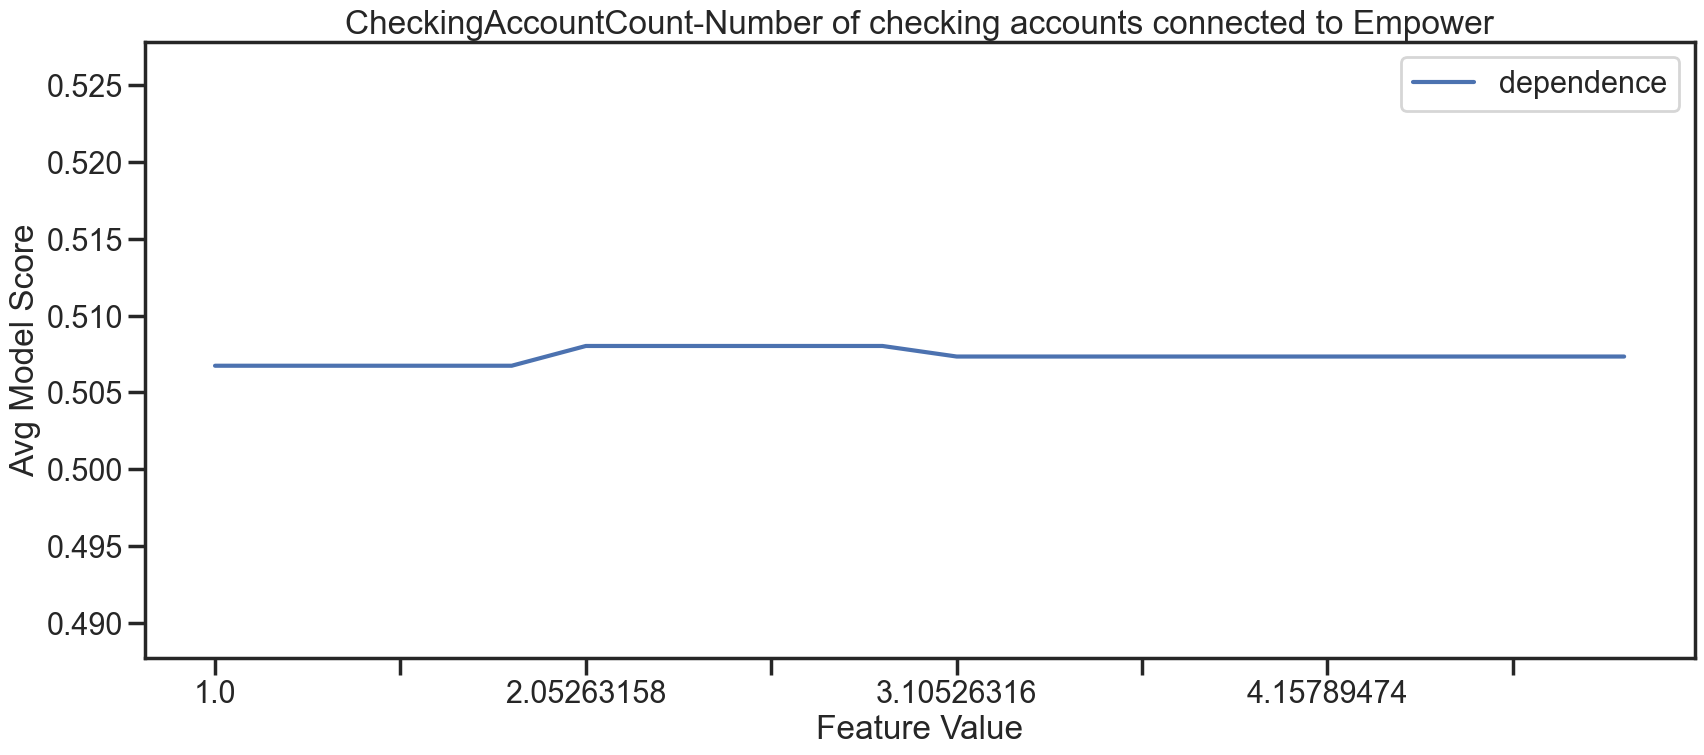

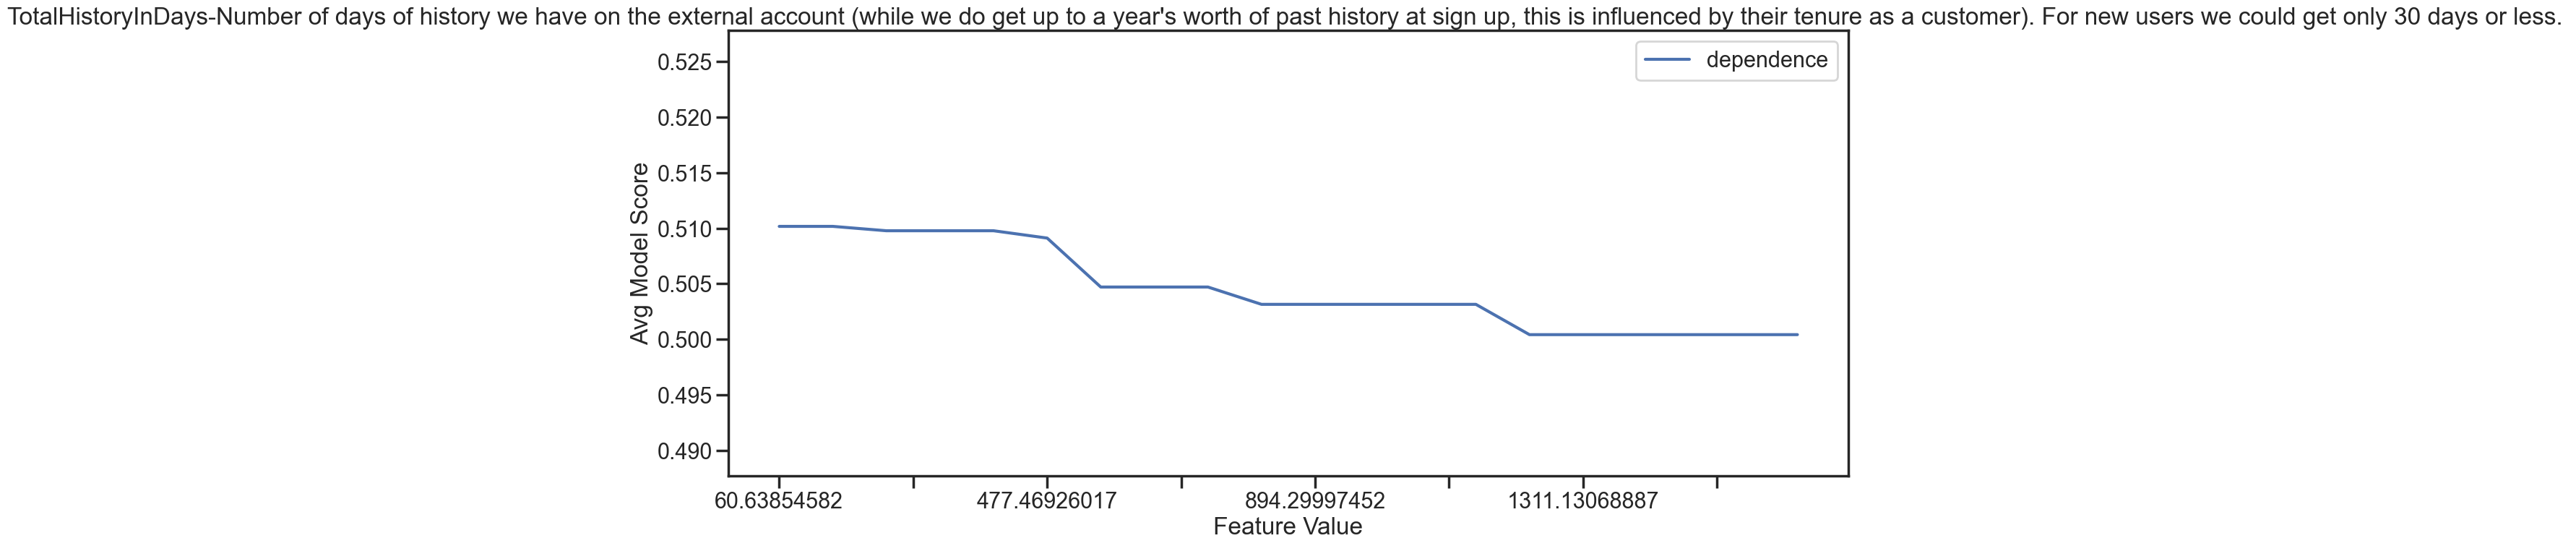

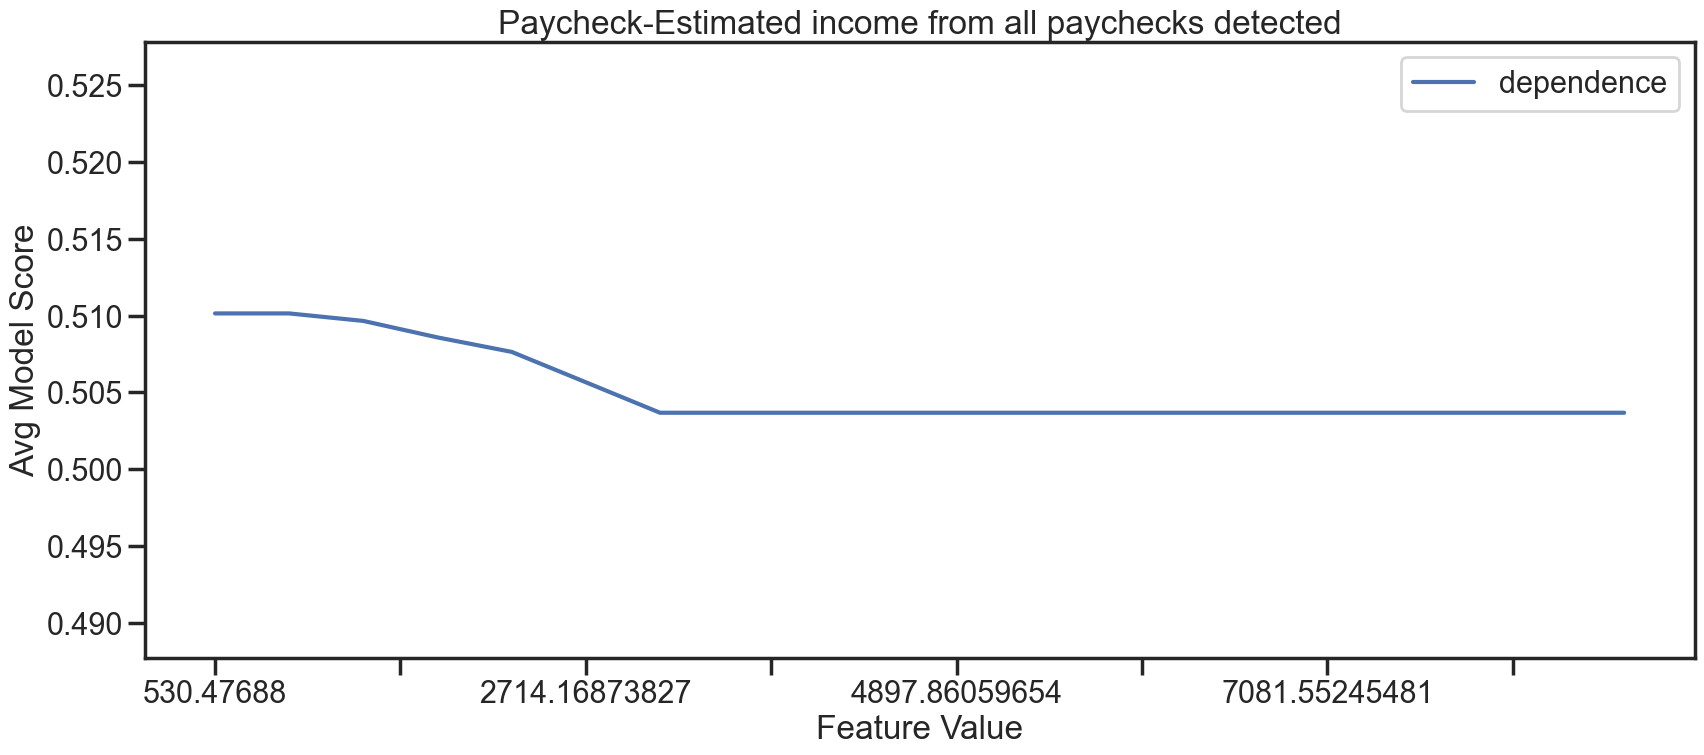

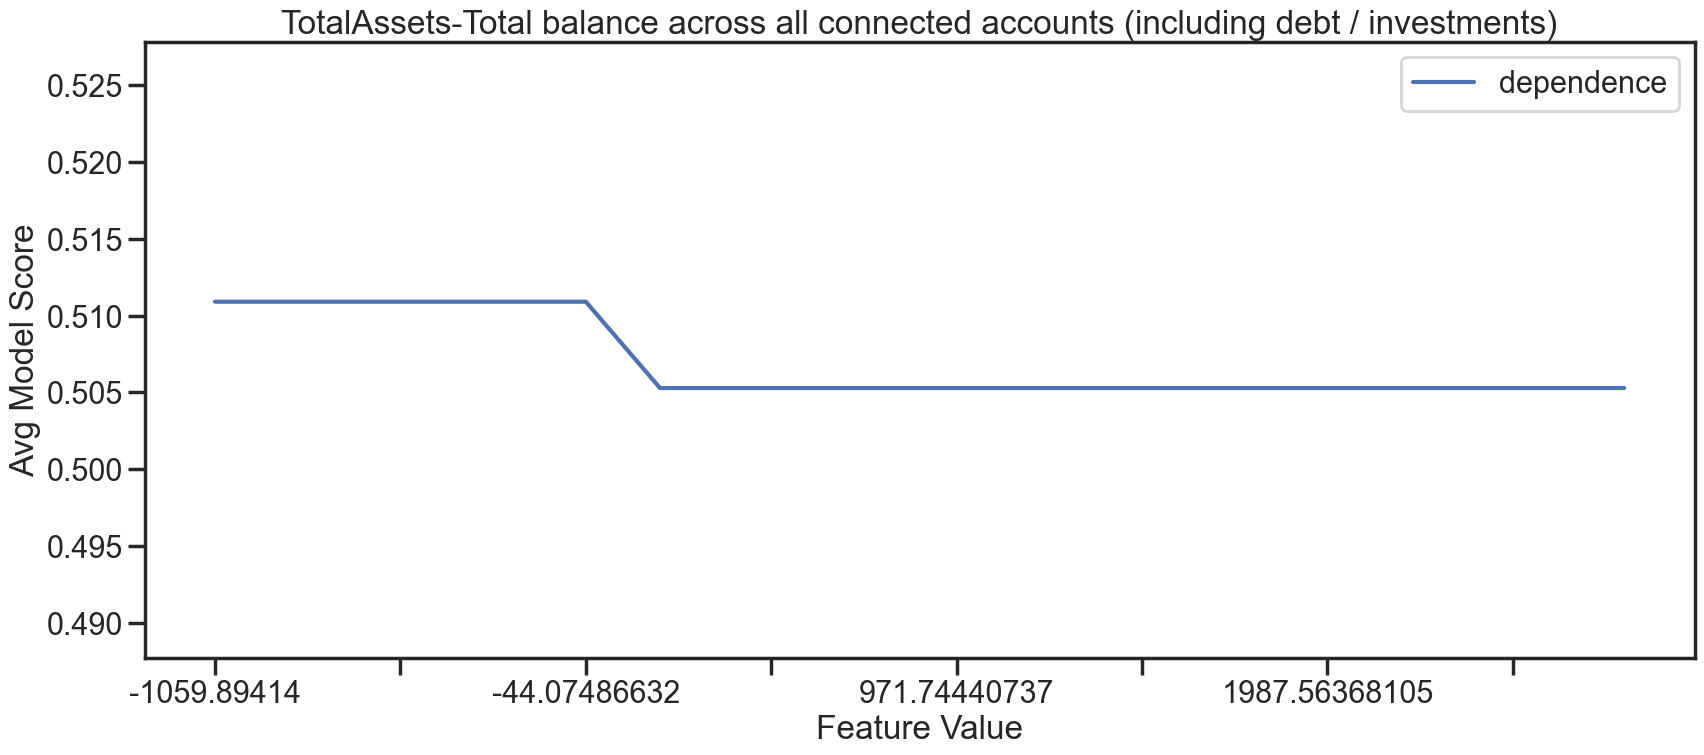

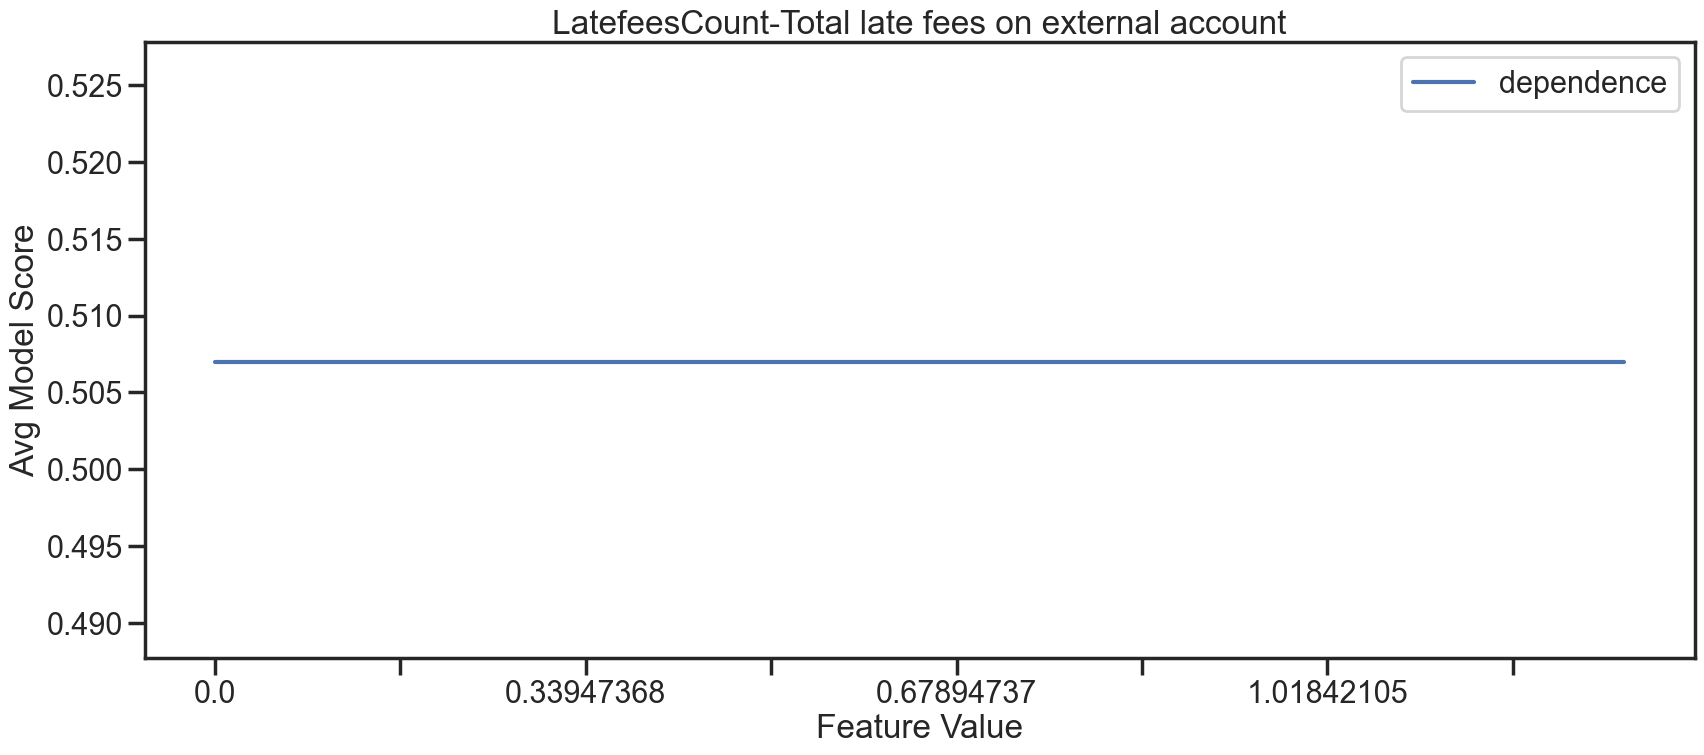

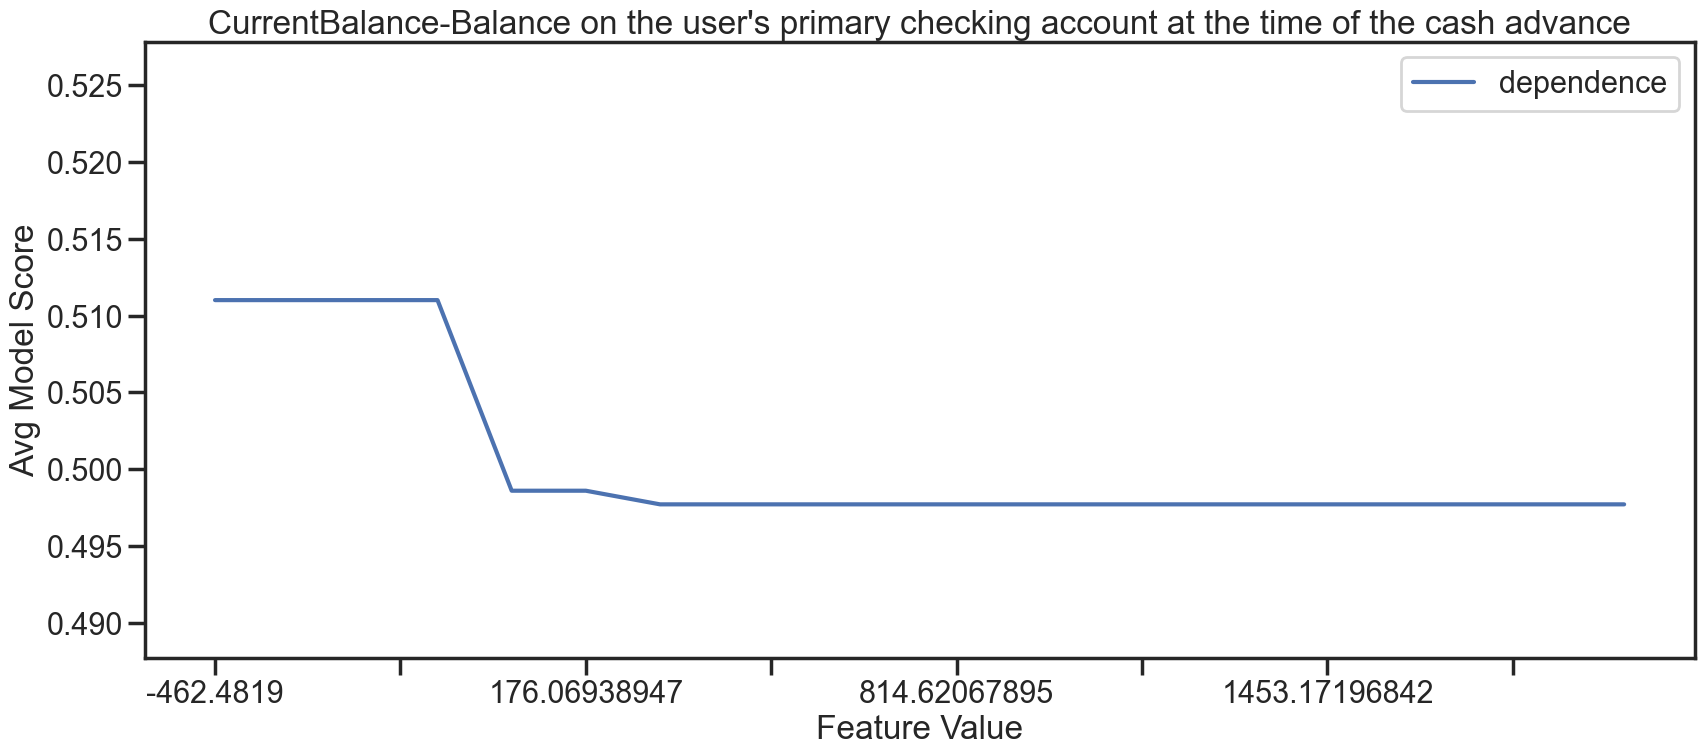

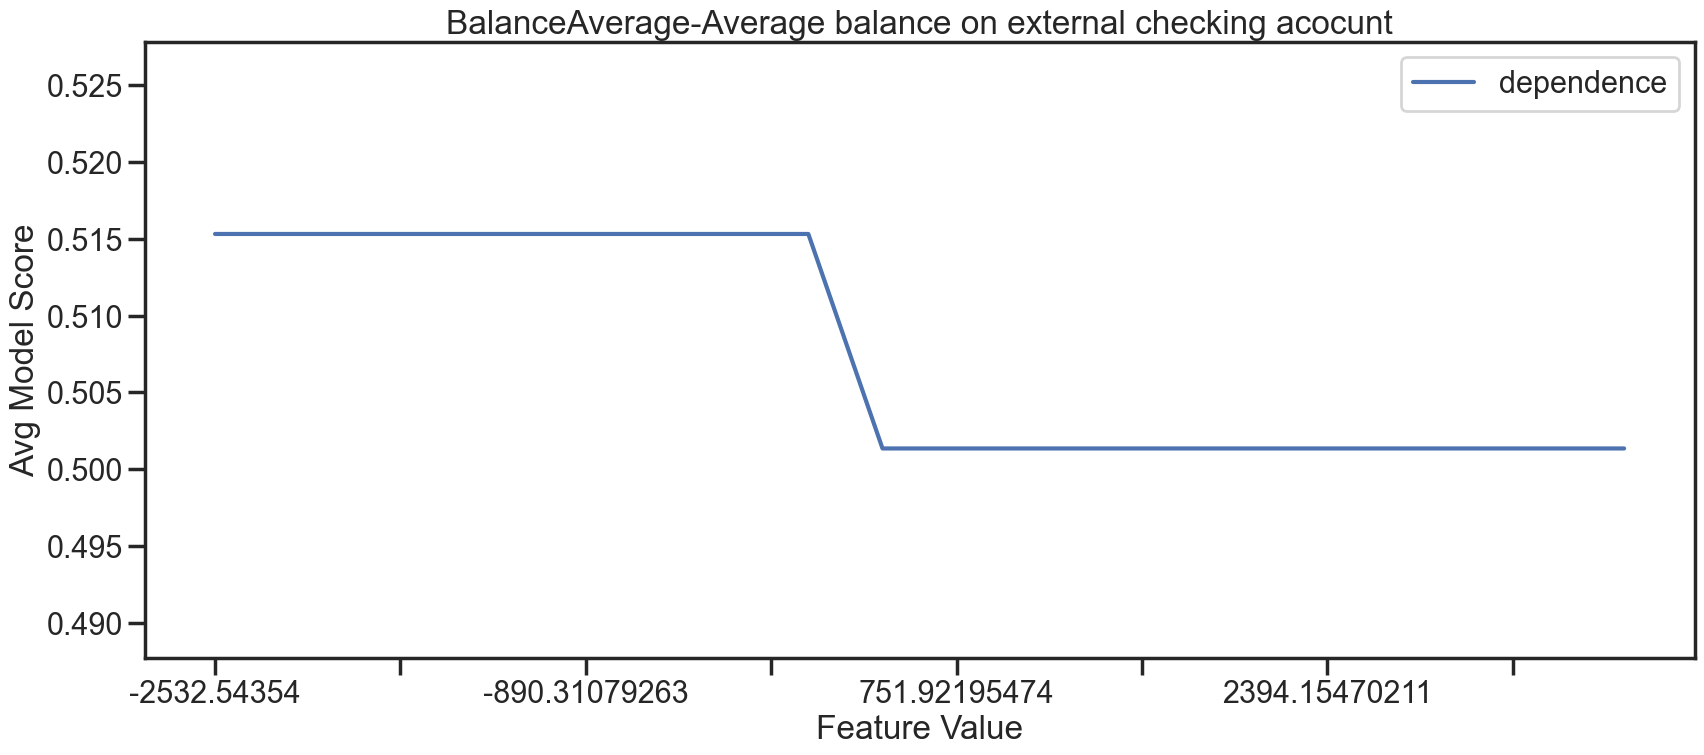

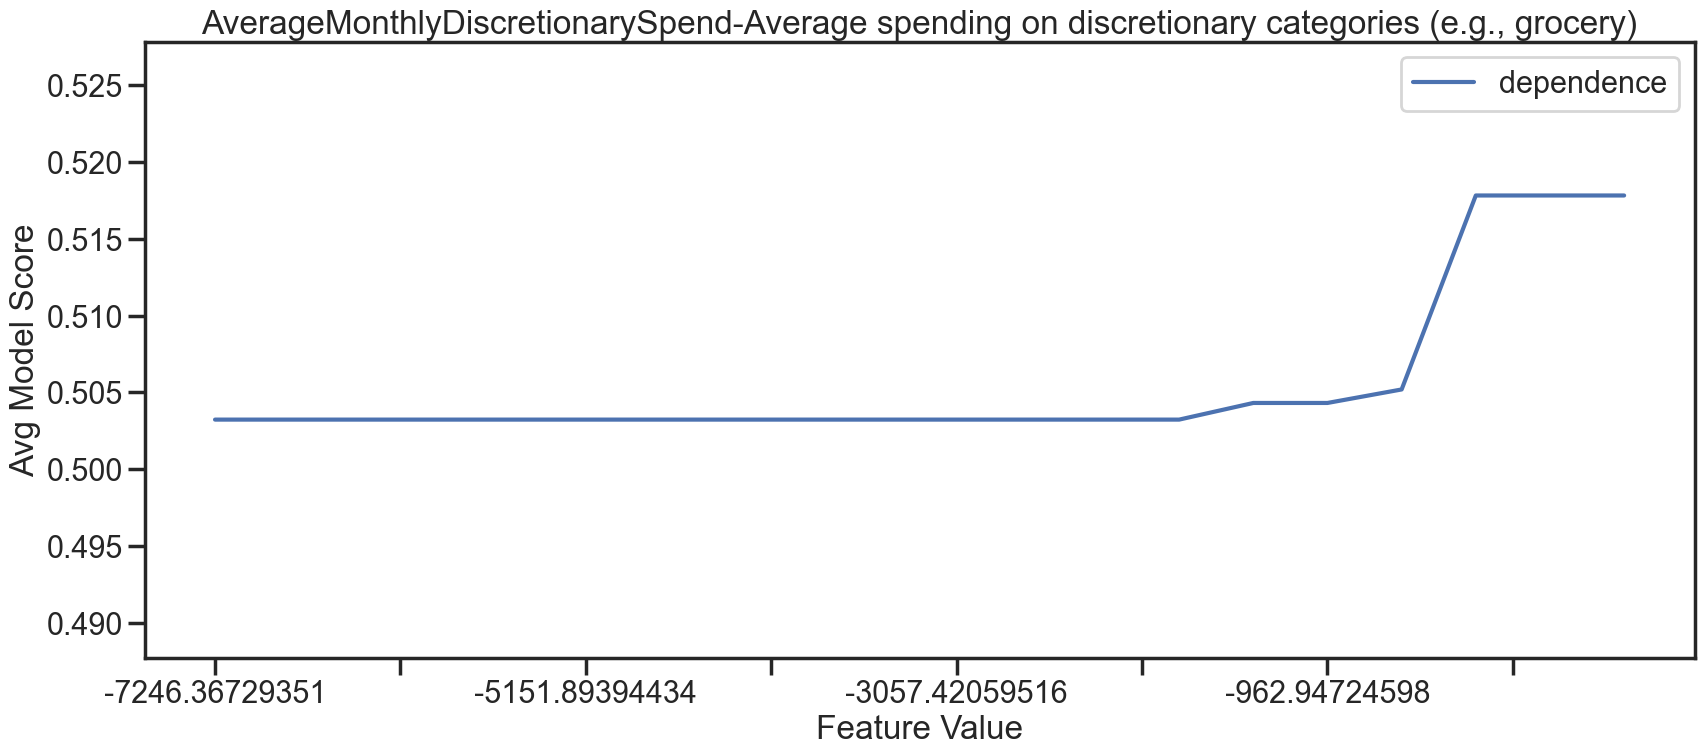

In [346]:
#generate PDP plots
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet

pdf_output = 'PDP_PLOTS.pdf'

doc = SimpleDocTemplate(pdf_output, pagesize = letter)

story = []

for attribute in tqdm(partial_dependence_plots['feature_name'].unique()):
    print(attribute.split('-')[0])
    pdp = partial_dependence_plots[partial_dependence_plots['feature_name'] == attribute]
    pdp = pdp[pdp['label'] != 'MISSING']
    pdp = pdp.dropna()
    pdp.plot(x = 'label', y = 'dependence')
    plt.xlabel('Feature Value')
    plt.ylabel('Avg Model Score')
    plt.title(attribute)
    plt.ylim(min_pdp_val, max_pdp_val)
    plt.savefig('./Images/' + attribute.split('-')[0] + '.png')
    
    # Append definiton of feature to PDF
    styles = getSampleStyleSheet()
    definition_para = Paragraph(list(pdp['feature'])[0], styles['Normal'])
    story.append(definition_para)
    story.append(Spacer(1, 20))
    
    # Append PNG file
    png_file = './Images/' + attribute.split('-')[0] + '.png'
    img = Image(png_file)
    img.drawHeight = 240
    img.drawWidth = 320
    story.append(img)
    story.append(Spacer(1, 20))
    

doc.build(story)

* Given that the data was filtered, we do not have the true distribution off our customers, thus its hard to look at counter intuitivity of the features
* I also look at Bi-Var Charts in some instances and compare them to the PDP or to check how that feature rank orders the target rate.

## Model Persistence

In [291]:
import pickle
with open('model.pickle', 'wb') as file:
    pickle.dump(pipeline, file)

In [295]:
import json
with open("features.json", "w") as json_file:
    json.dump(list(features), json_file, indent=2)

In [297]:
with open('features.json') as f:
    final_features = json.load(f)
len(final_features)

23

In [296]:
with open('model.pickle', 'rb') as file:
    pipeline = pickle.load(file)

In [305]:
customer = df[features].sample(1, random_state = 42)

In [309]:
pipeline.predict_proba(customer)[:,1][0]

Imputation complete.....
Imputation complete.....


0.46659982

## Future Directions:
* Drop the 5 features that had 0 importance and then refit, I dont expect we need to tune again as from experience, these features do have any effect on the model